(gp-birthdays)=
# Baby Births Modelling with HSGP

:::{post} January, 2024
:tags: gaussian processes, hilbert space approximation,
:category: intermediate, how-to
:author: [Juan Orduz](https://juanitorduz.github.io/)
:::

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from matplotlib.ticker import MaxNLocator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "birthdays"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

In [3]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/avehtari/casestudies/master/Birthdays/data/births_usa_1969.csv",
)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          7305 non-null   int64
 1   month         7305 non-null   int64
 2   day           7305 non-null   int64
 3   births        7305 non-null   int64
 4   day_of_year   7305 non-null   int64
 5   day_of_week   7305 non-null   int64
 6   id            7305 non-null   int64
 7   day_of_year2  7305 non-null   int64
dtypes: int64(8)
memory usage: 456.7 KB


In [4]:
raw_df.head()

,year,month,day,births,day_of_year,day_of_week,id,day_of_year2
0,1969,1,1,8486,1,3,1,1
1,1969,1,2,9002,2,4,2,2
2,1969,1,3,9542,3,5,3,3
3,1969,1,4,8960,4,6,4,4
4,1969,1,5,8390,5,7,5,5


## EDA and Feature Engineering

Text(0.5, 1.0, 'Number of Births in the USA in 1969 - 1988')

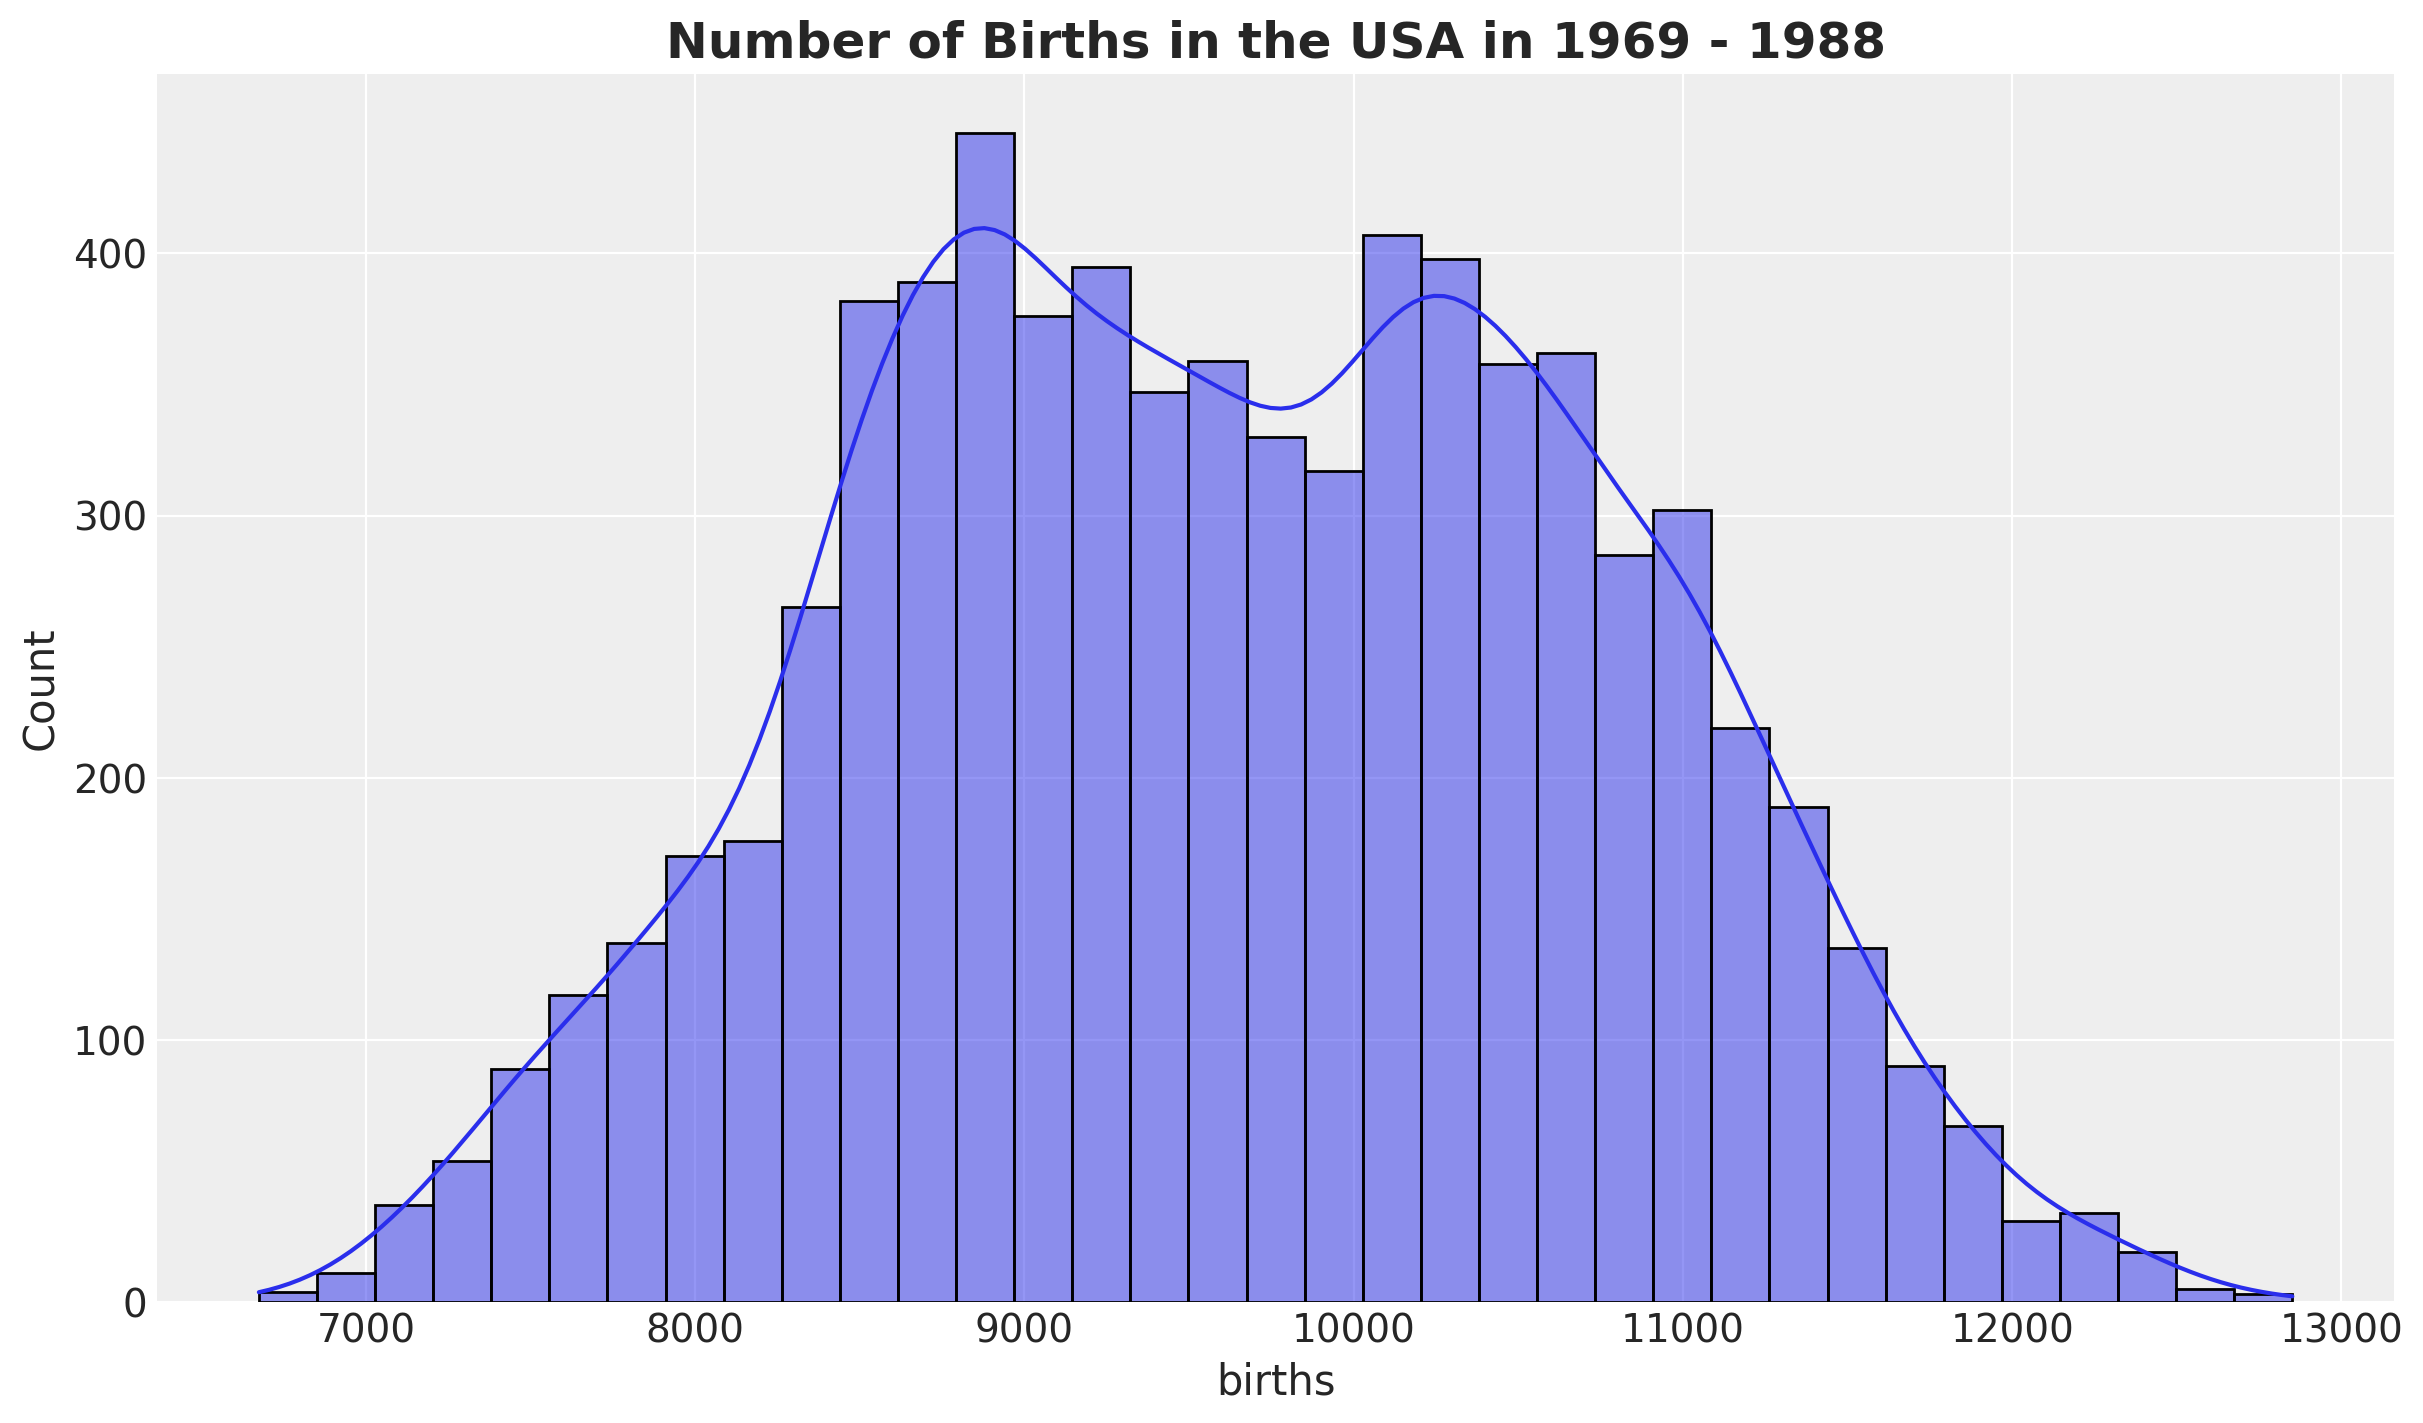

In [5]:
fig, ax = plt.subplots()
sns.histplot(data=raw_df, x="births", kde=True, ax=ax)
ax.set_title(
    label="Number of Births in the USA in 1969 - 1988",
    fontsize=18,
    fontweight="bold",
)

In [6]:
data_df = raw_df.copy().assign(
    date=lambda x: pd.to_datetime(x[["year", "month", "day"]]),
    births_relative100=lambda x: x["births"] / x["births"].mean() * 100,
    obs=lambda x: x.index,
)

Text(0.5, 1.0, 'Relative Births in the USA in 1969 - 1988')

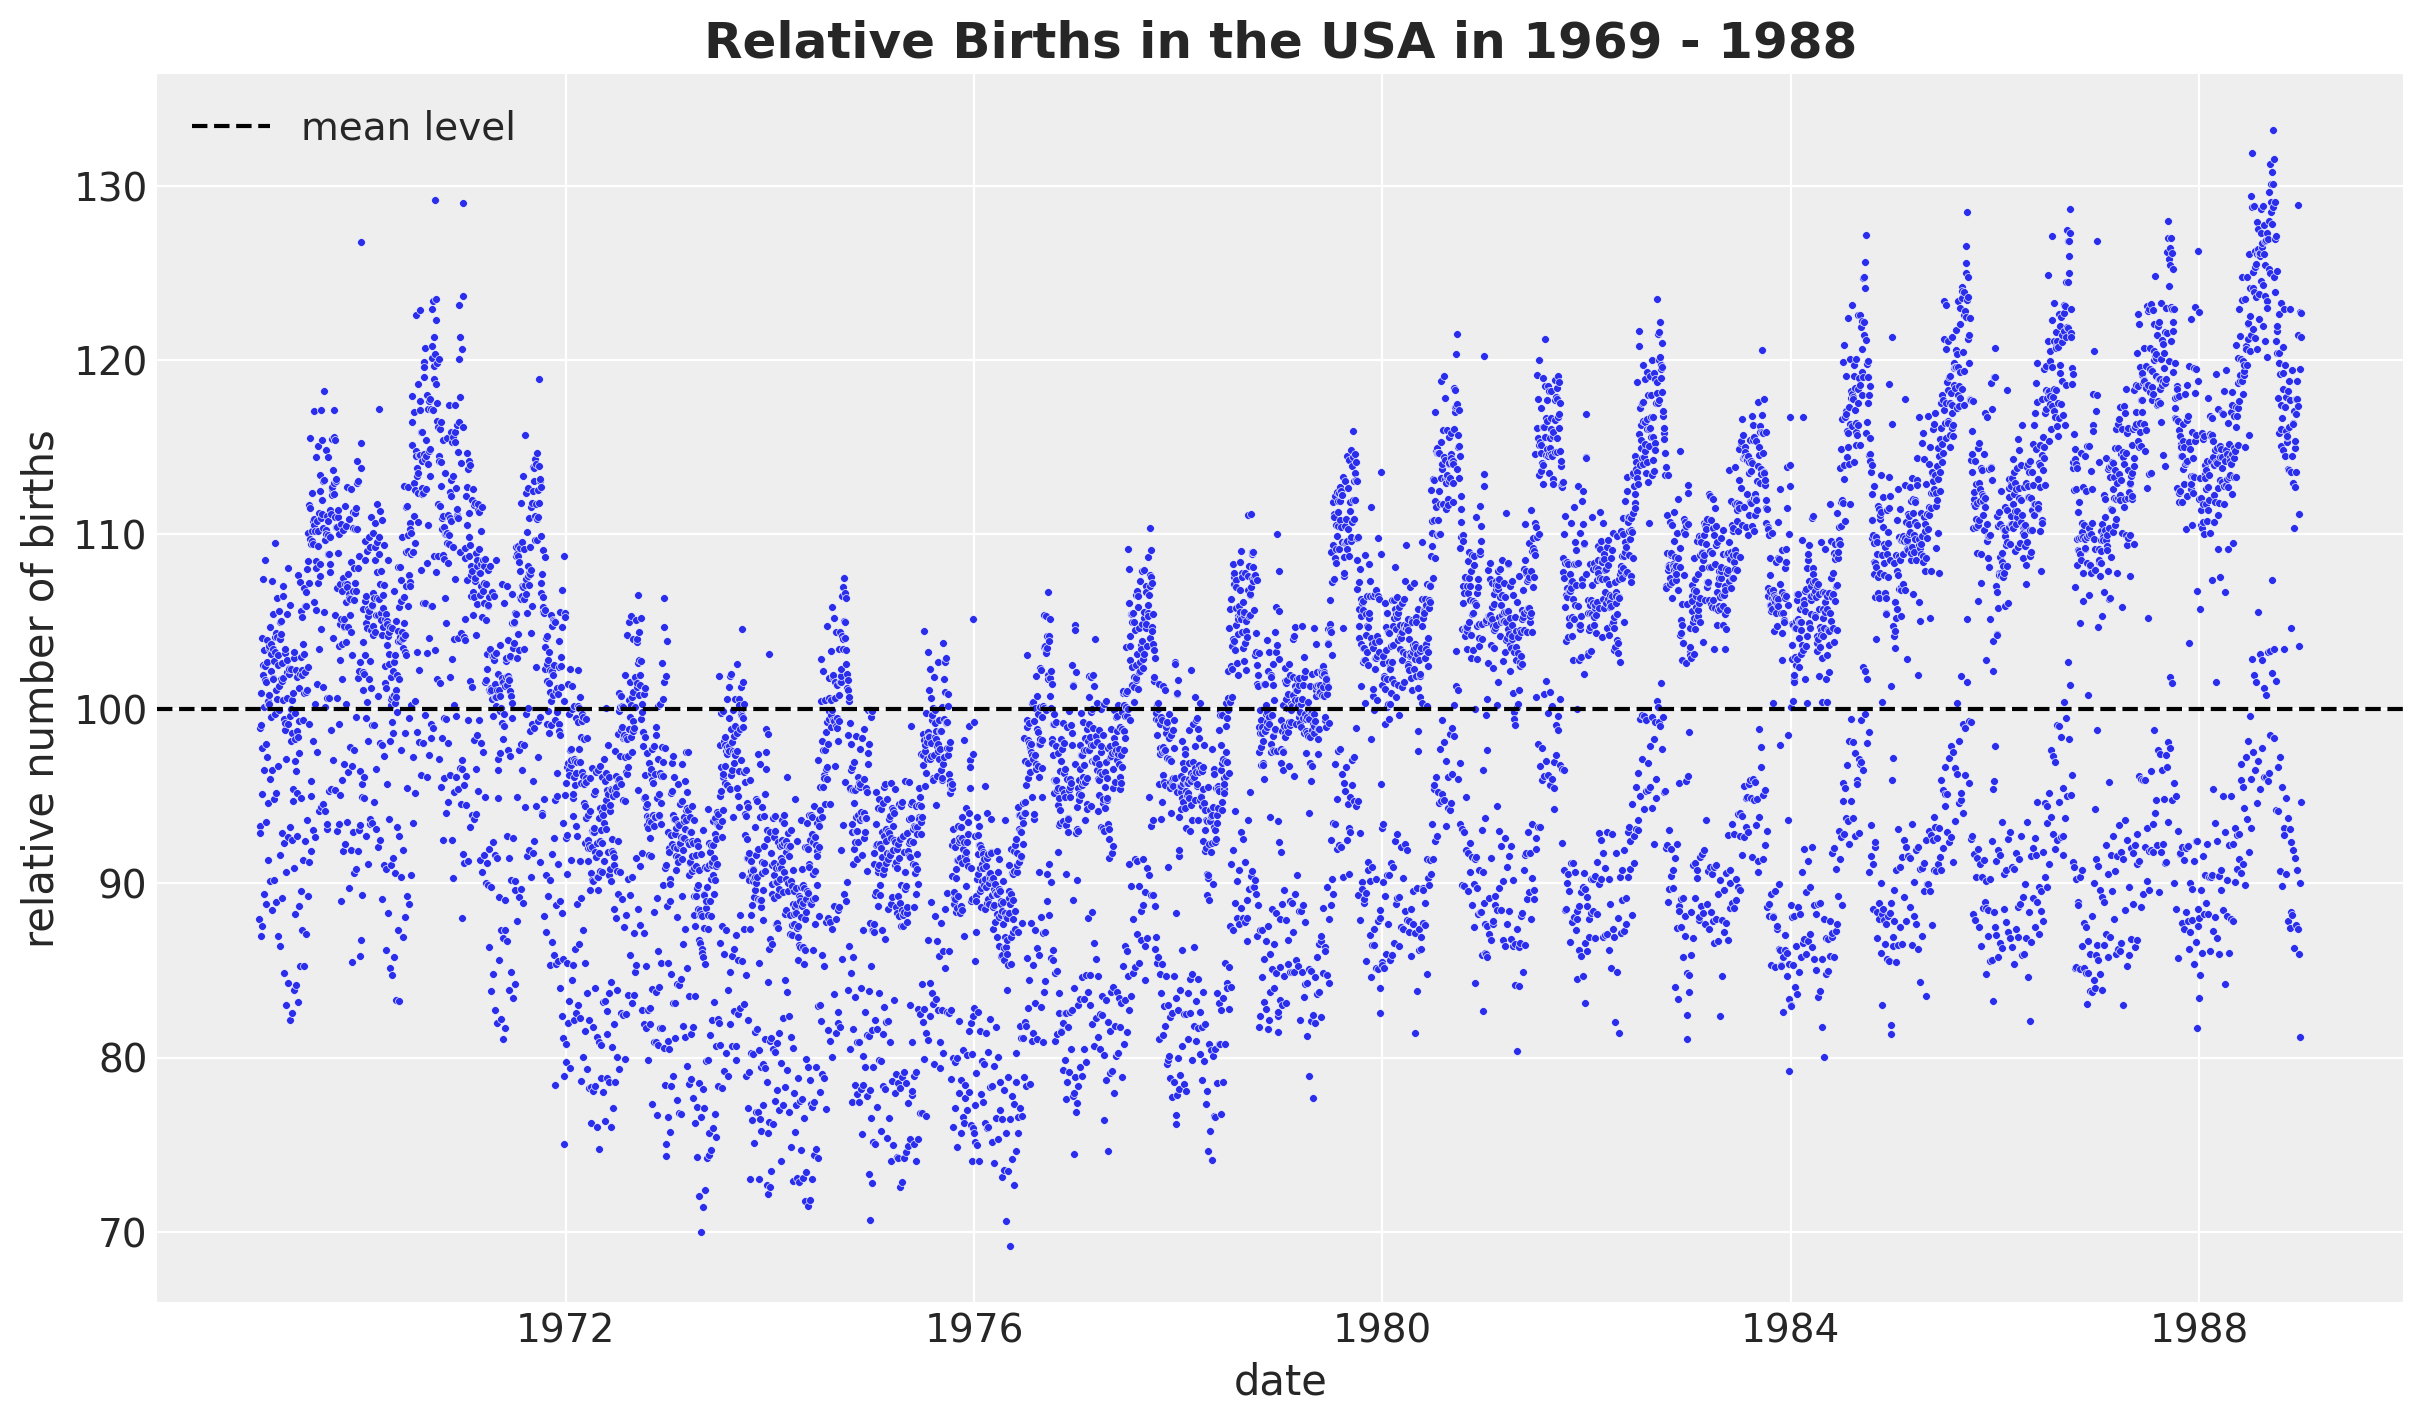

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="date", y="births_relative100", c="C0", s=8, ax=ax)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(
    label="Relative Births in the USA in 1969 - 1988", fontsize=18, fontweight="bold"
)

Text(0.5, 1.0, 'Relative Births in the USA in 1969 - 1988\nMean over Day of Year')

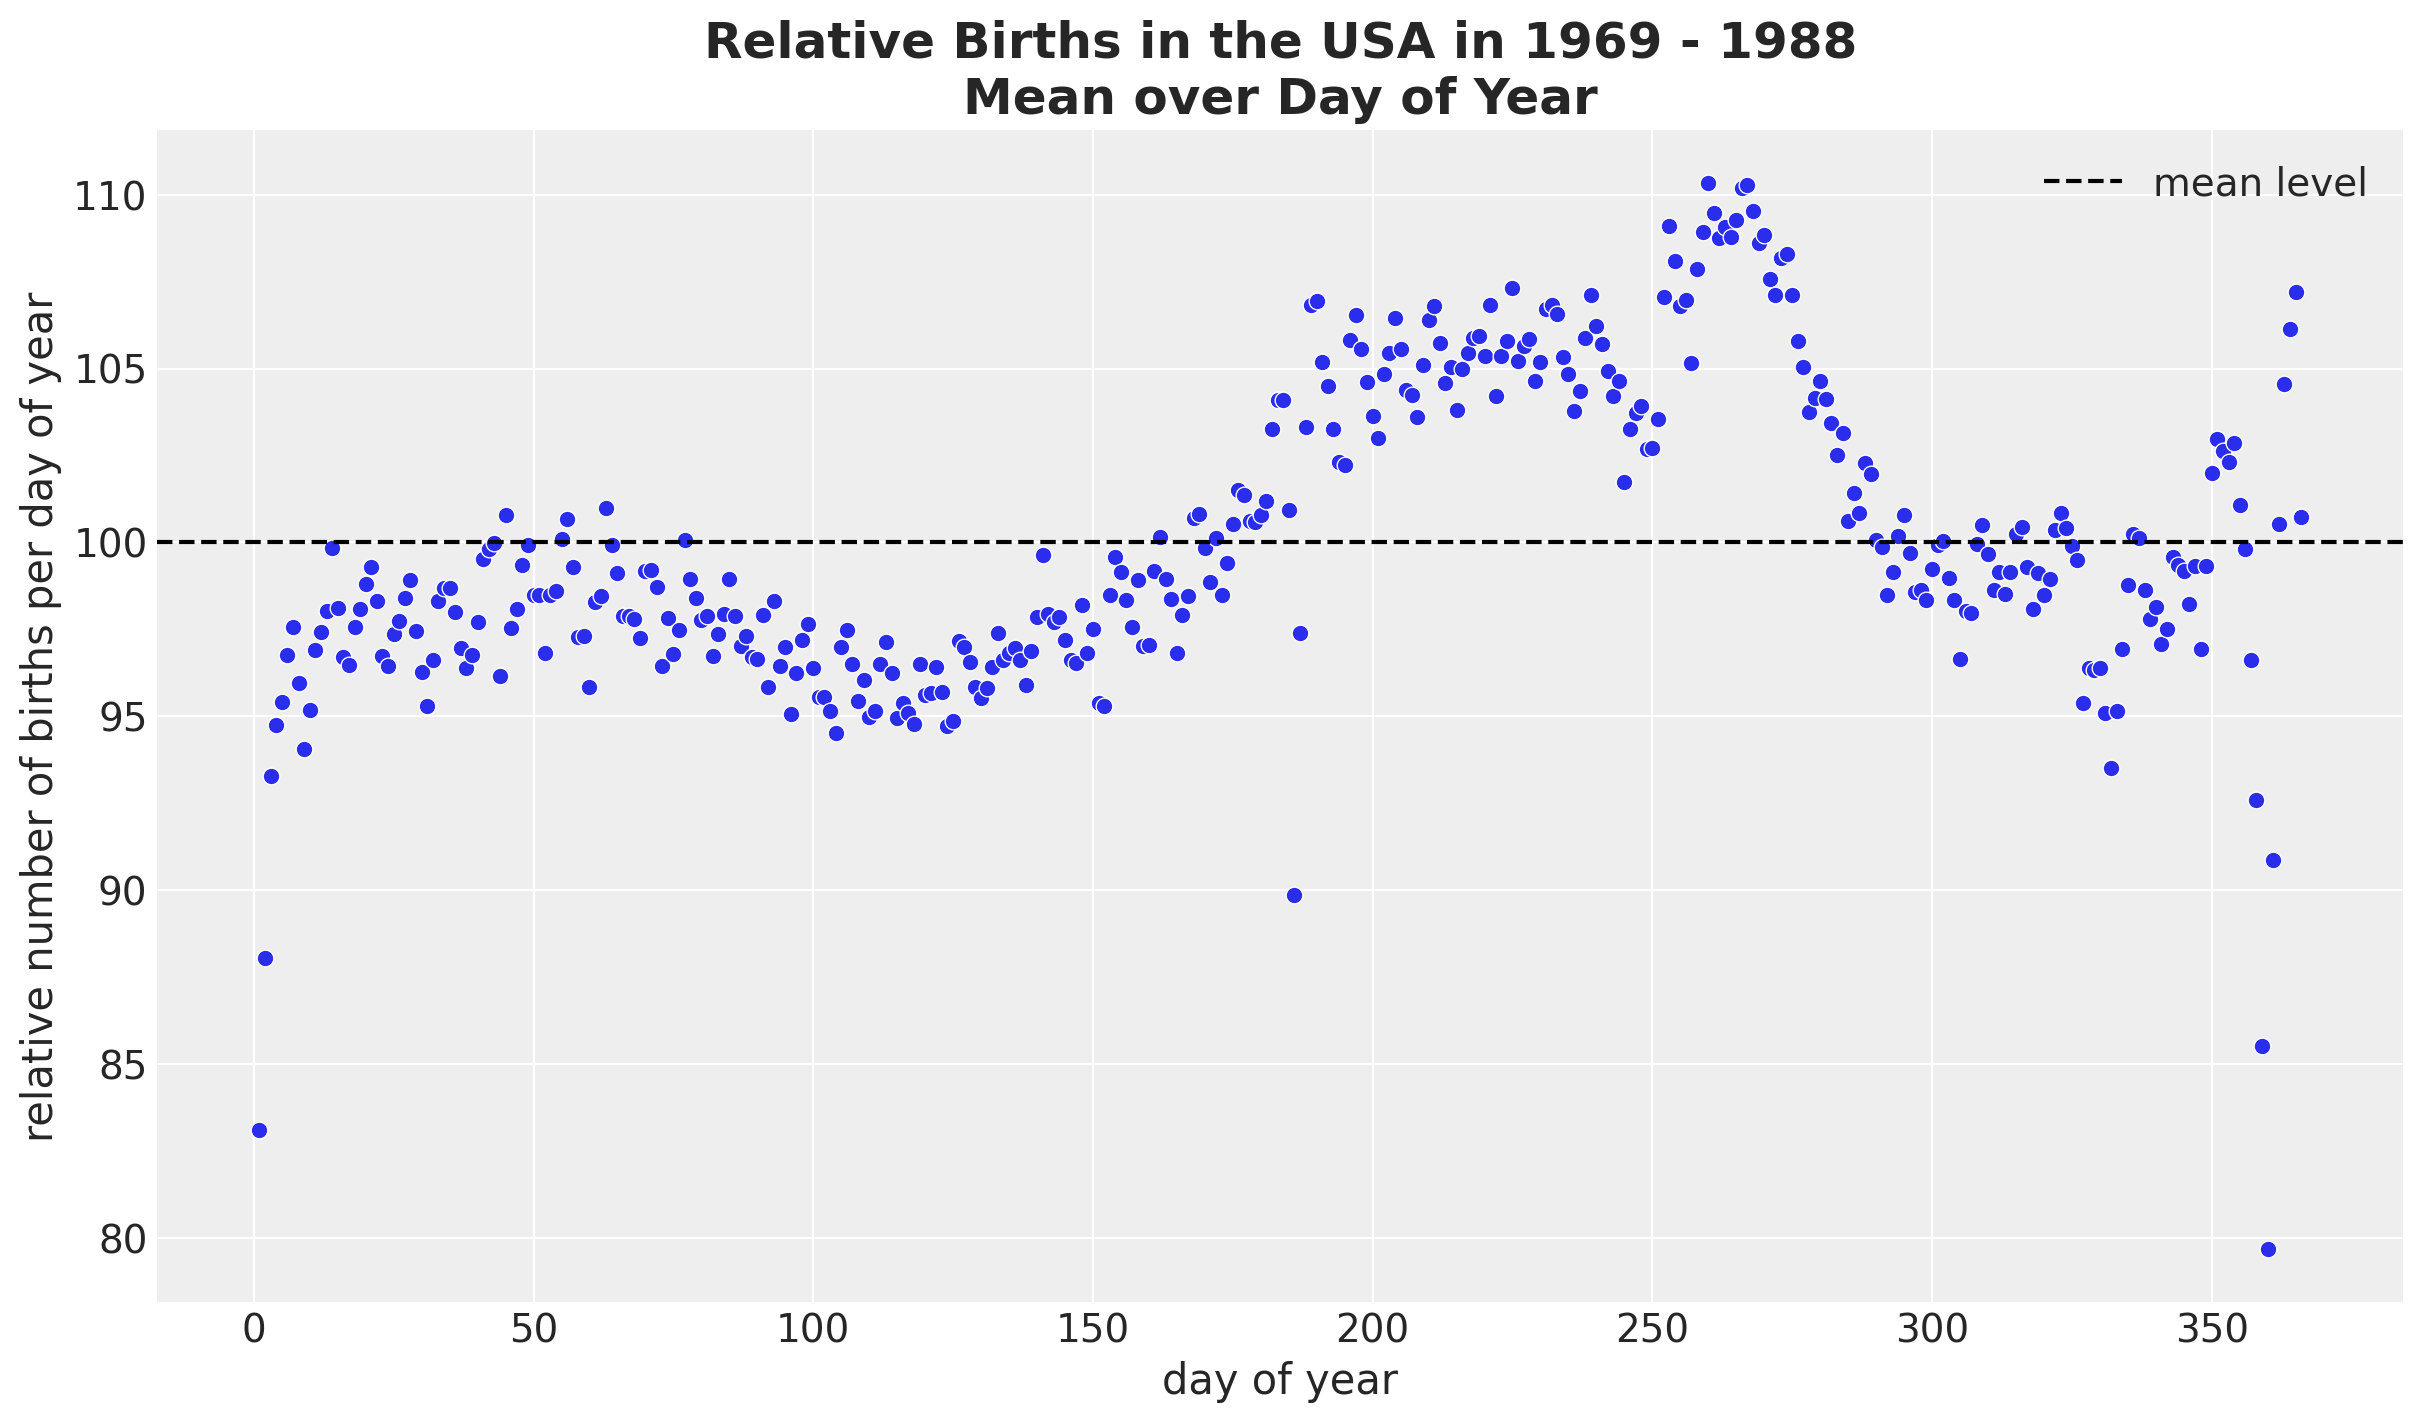

In [8]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_year2"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe((sns.scatterplot, "data"), x="day_of_year2", y="meanbirths", c="C0", ax=ax)
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of year", ylabel="relative number of births per day of year")
ax.set_title(
    label="Relative Births in the USA in 1969 - 1988\nMean over Day of Year",
    fontsize=18,
    fontweight="bold",
)

Text(0.5, 1.0, 'Relative Births in the USA in 1969 - 1988\nMean over Month and Year')

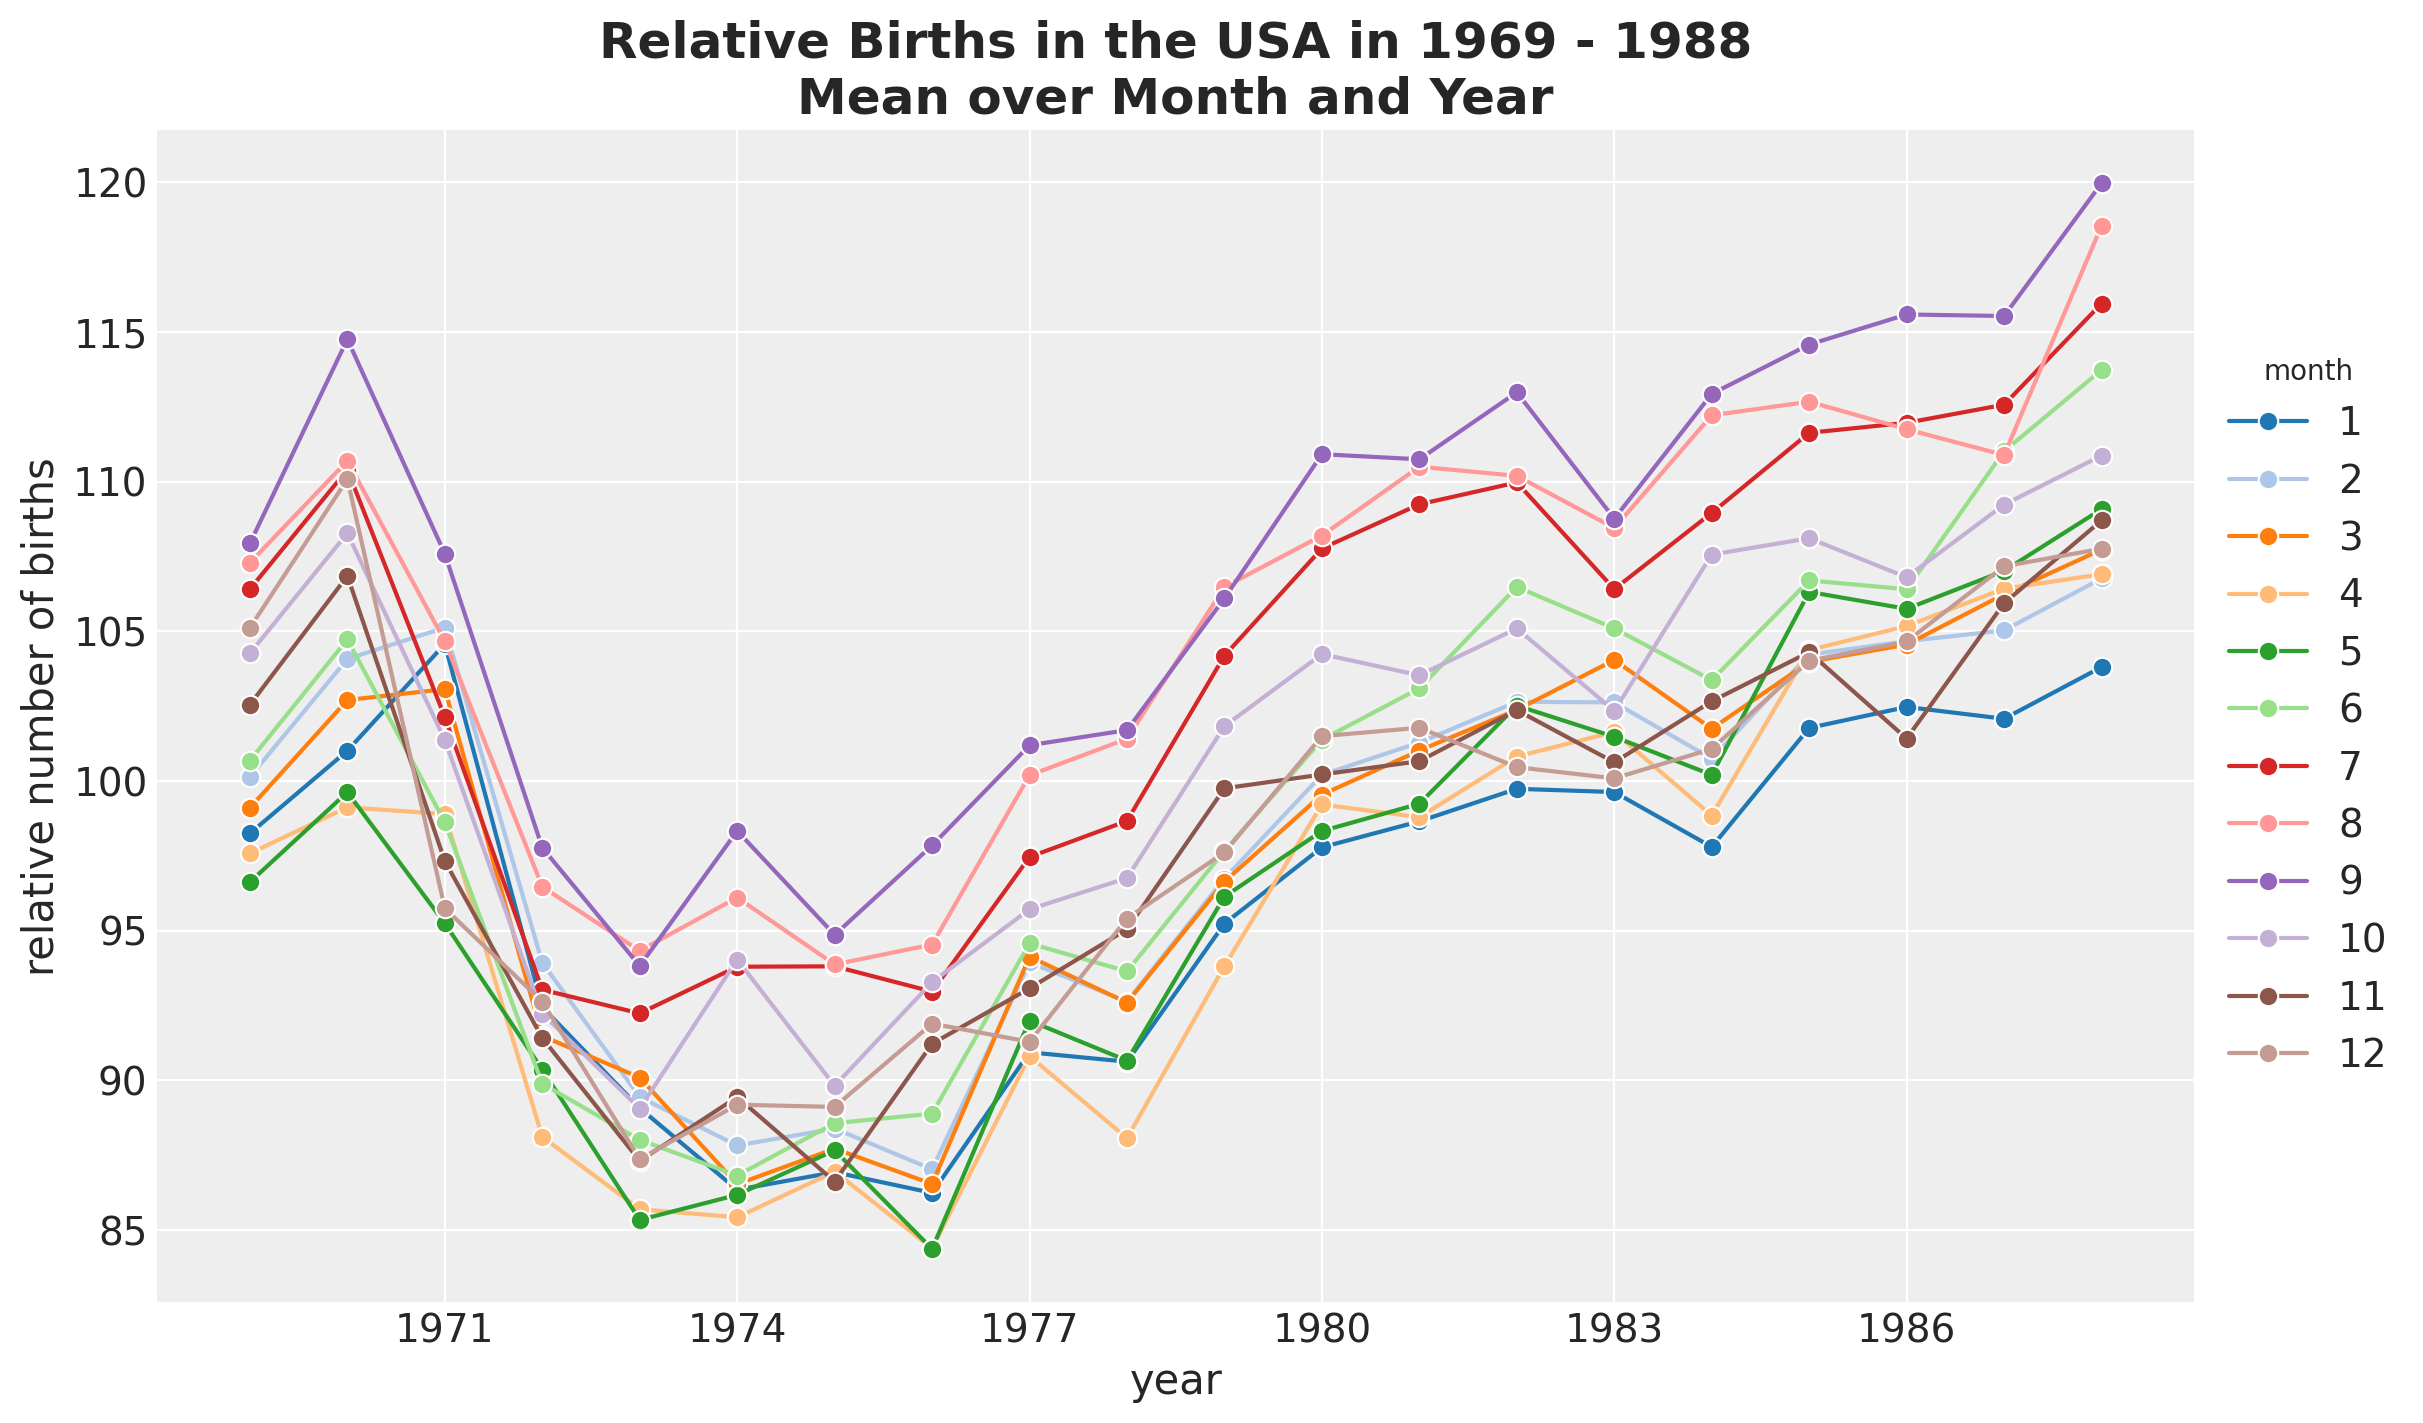

In [9]:
fig, ax = plt.subplots()
(
    data_df.groupby(["year", "month"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .assign(month=lambda x: pd.Categorical(x["month"]))
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="meanbirths",
        marker="o",
        markersize=7,
        hue="month",
        palette="tab20",
    )
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title="month", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel="year", ylabel="relative number of births")
ax.set_title(
    label="Relative Births in the USA in 1969 - 1988\nMean over Month and Year",
    fontsize=18,
    fontweight="bold",
)

Text(0.5, 1.0, 'Relative Births in the USA in 1969 - 1988\nMean over Day of Week')

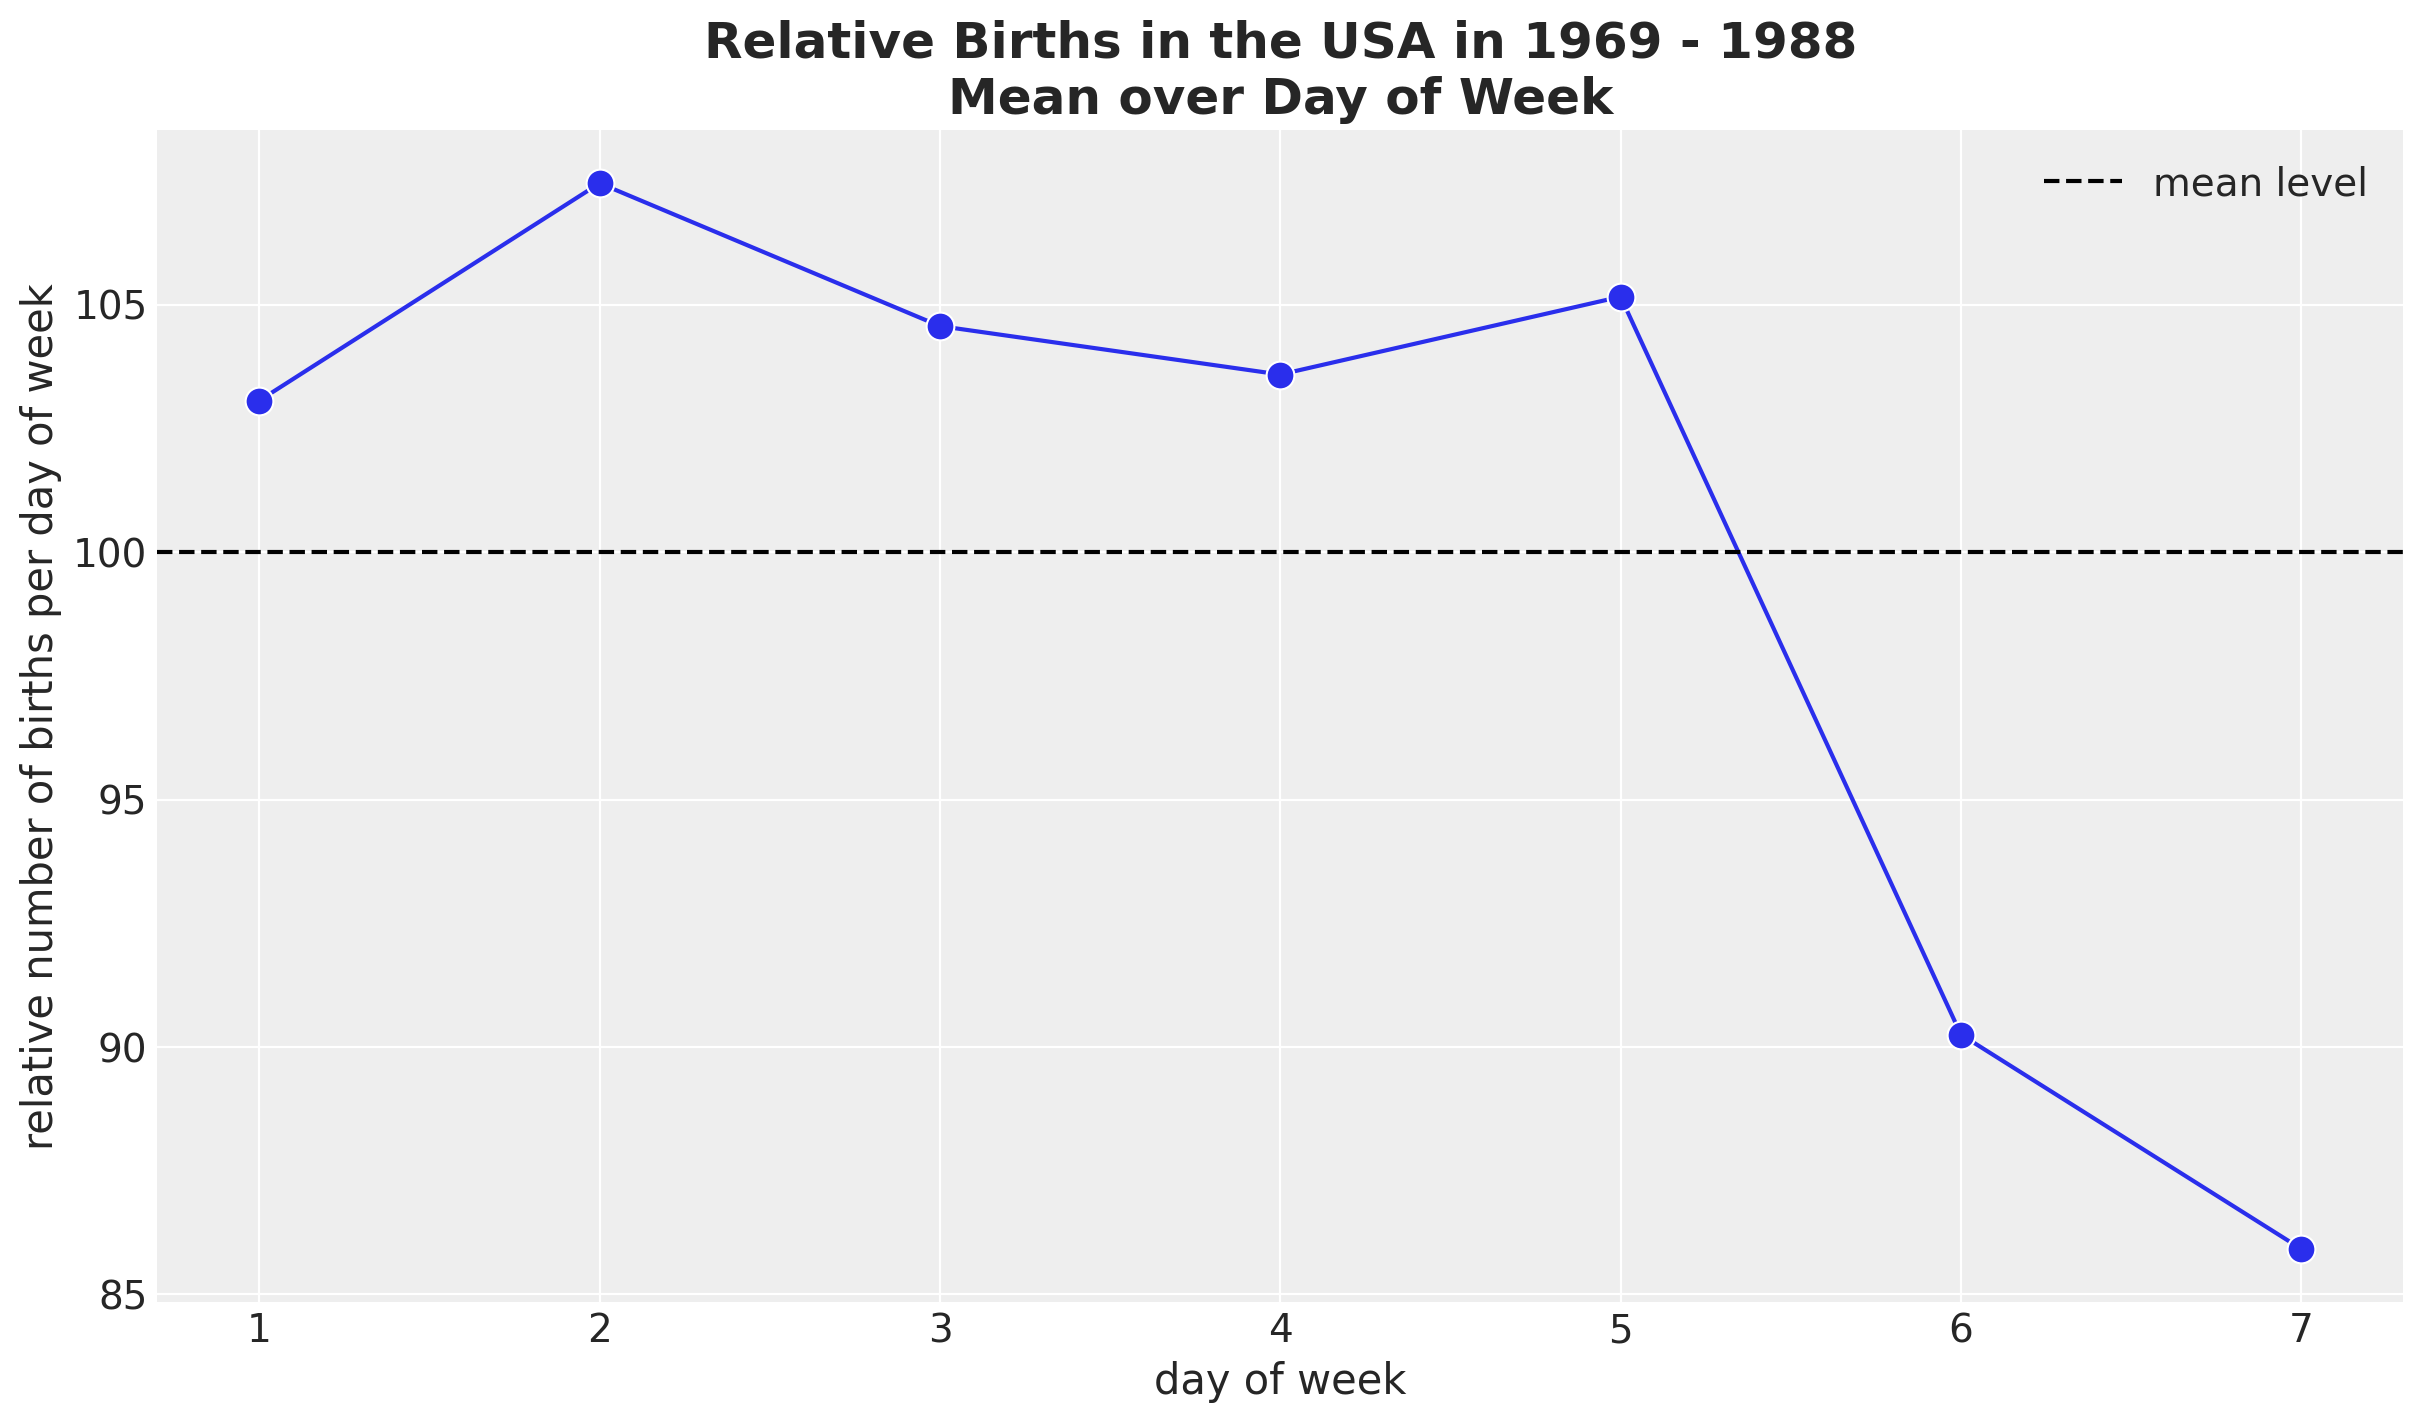

In [10]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_week"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe(
        (sns.lineplot, "data"),
        x="day_of_week",
        y="meanbirths",
        marker="o",
        c="C0",
        markersize=10,
        ax=ax,
    )
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of week", ylabel="relative number of births per day of week")
ax.set_title(
    label="Relative Births in the USA in 1969 - 1988\nMean over Day of Week",
    fontsize=18,
    fontweight="bold",
)

Text(0.5, 1.0, 'Relative Births in the USA in 1969 - 1988\nMean over Day of Week and Year')

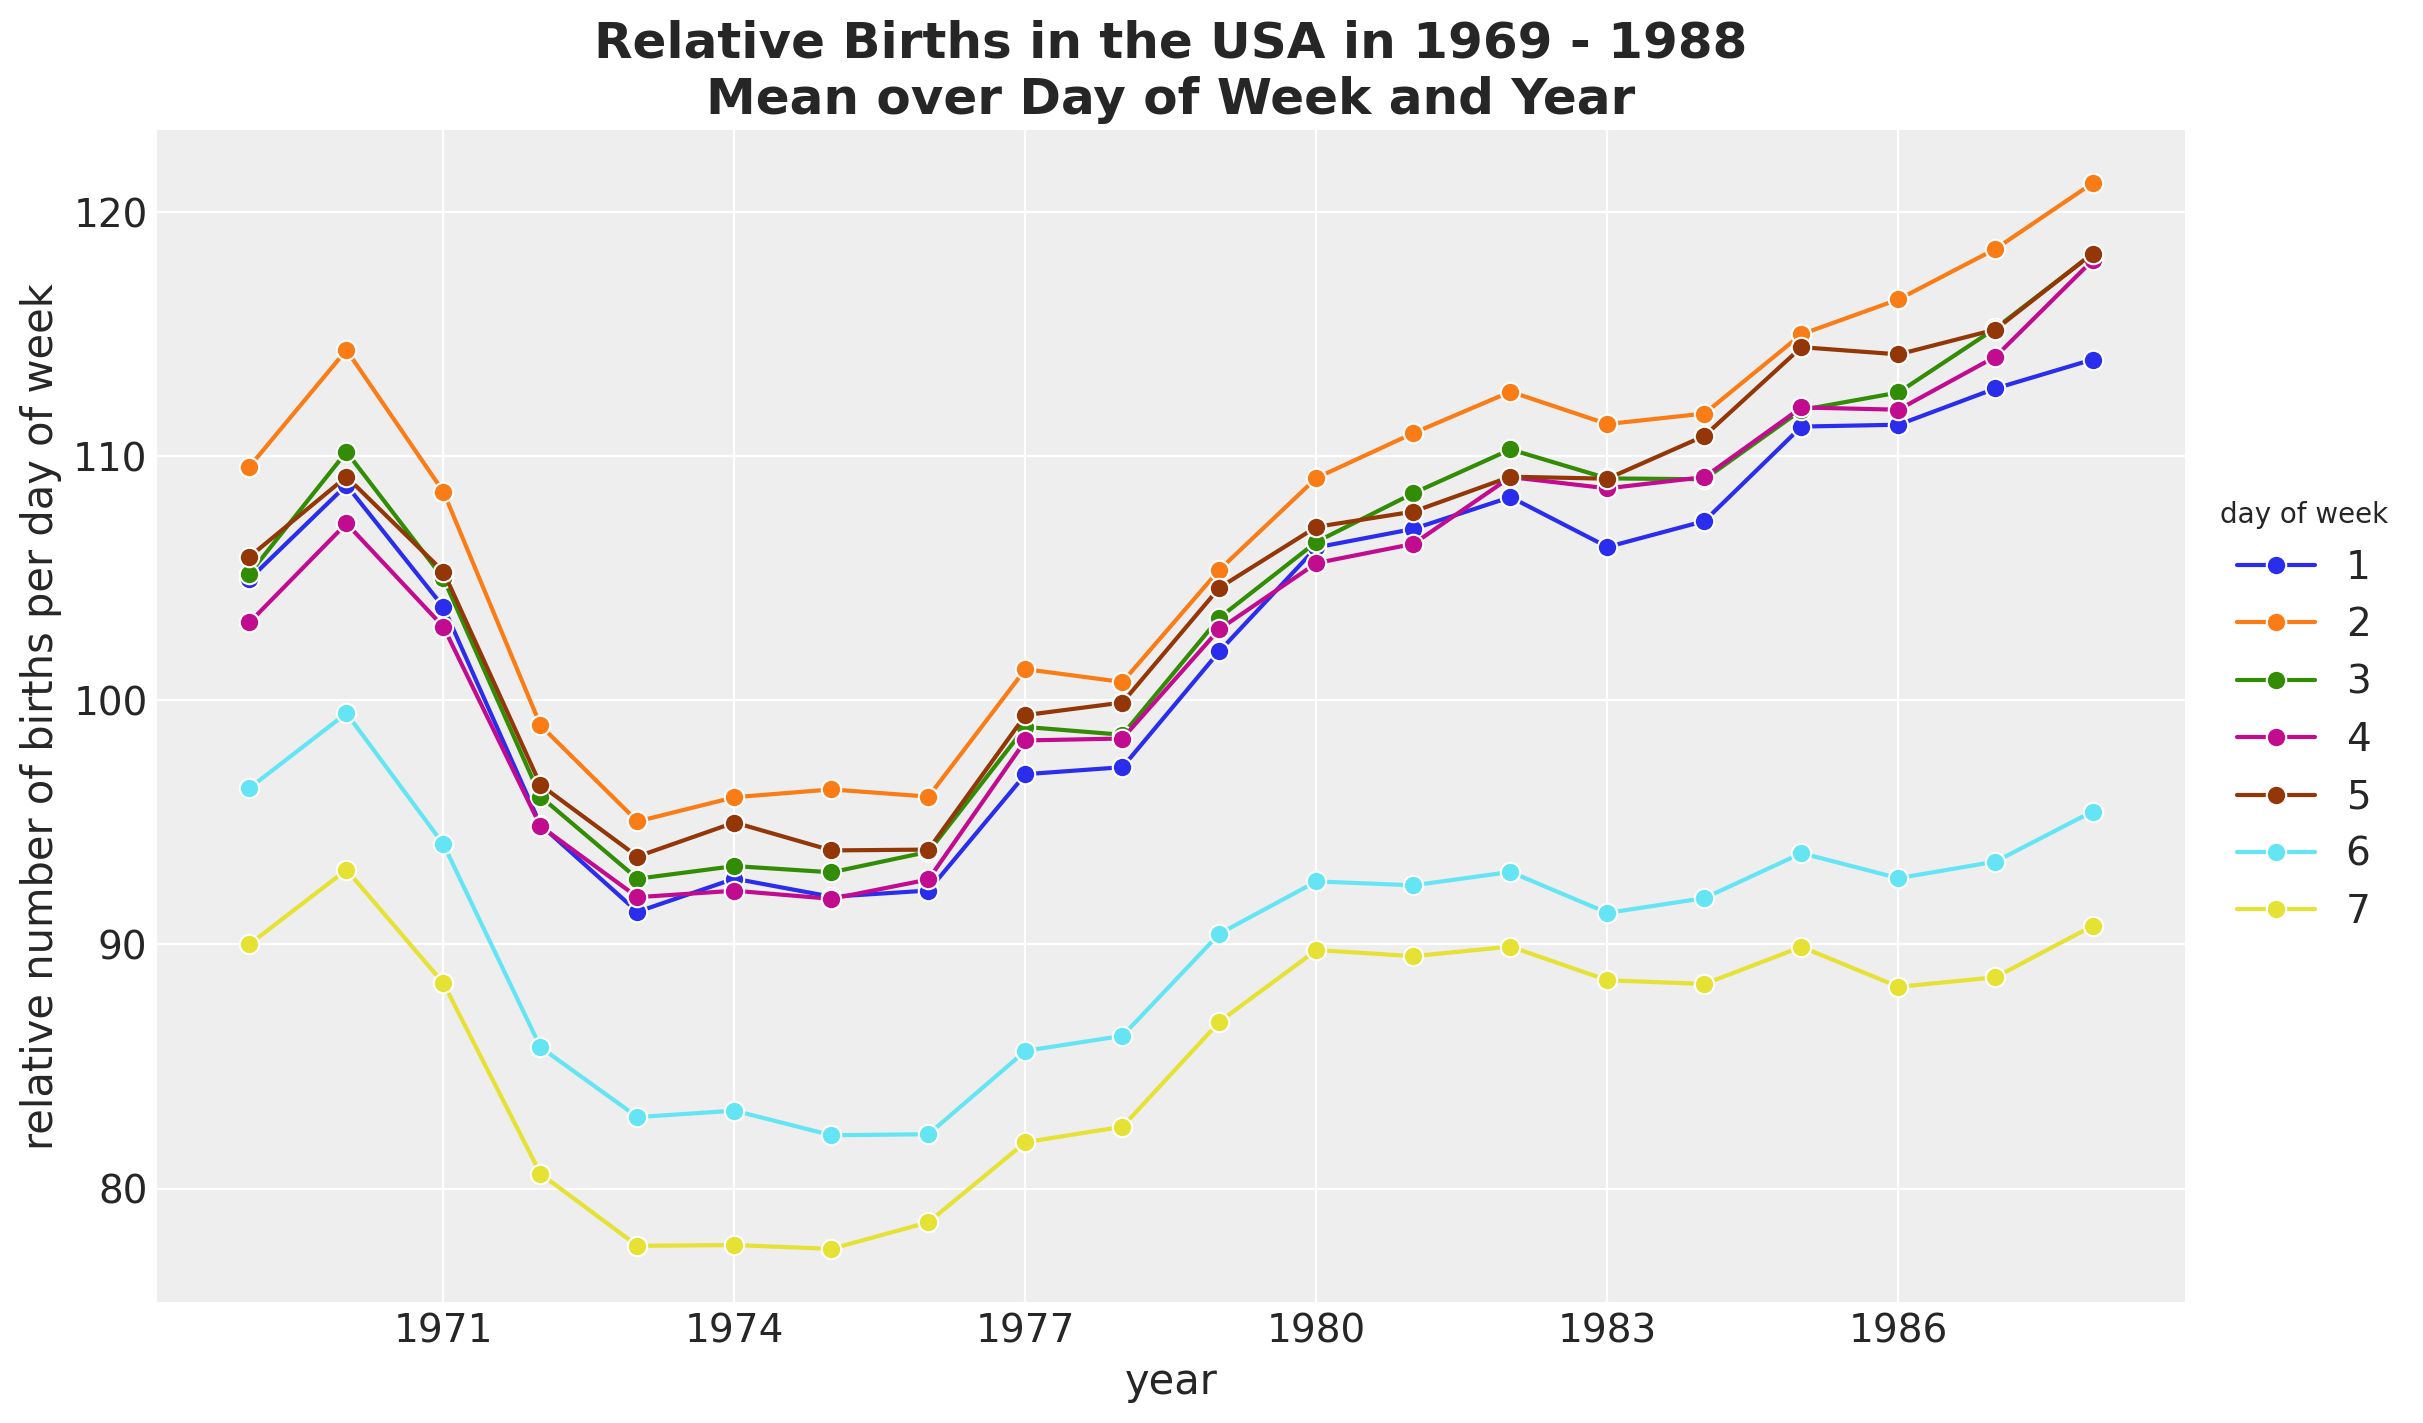

In [11]:
fig, ax = plt.subplots()
(
    data_df.groupby(["year", "day_of_week"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .assign(day_of_week=lambda x: pd.Categorical(x["day_of_week"]))
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="meanbirths",
        marker="o",
        markersize=7,
        hue="day_of_week",
    )
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title="day of week", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel="year", ylabel="relative number of births per day of week")
ax.set_title(
    label="Relative Births in the USA in 1969 - 1988\nMean over Day of Week and Year",
    fontsize=18,
    fontweight="bold",
)

## Data Pre-Processing

In [12]:
n = data_df.shape[0]
obs = data_df["obs"].to_numpy()
date = data_df["date"].to_numpy()
year = data_df["year"].to_numpy()
day_of_week_idx, day_of_week = data_df["day_of_week"].factorize(sort=True)
day_of_year2_idx, day_of_year2 = data_df["day_of_year2"].factorize(sort=True)
births_relative100 = data_df["births_relative100"].to_numpy()

In [13]:
# we want to use the scale of the data size to set up the priors.
# we are mainly interested in the standard deviation.
obs_pipeline = Pipeline(steps=[("scaler", StandardScaler())])
obs_pipeline.fit(obs.reshape(-1, 1))
normalized_obs = obs_pipeline.transform(obs.reshape(-1, 1)).flatten()
obs_std = obs_pipeline["scaler"].scale_.item()

# we first take a log transform and then normalize the data.
births_relative100_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)
births_relative100_pipeline.fit(births_relative100.reshape(-1, 1))
normalized_log_births_relative100 = births_relative100_pipeline.transform(
    births_relative100.reshape(-1, 1)
).flatten()
normalized_log_births_relative100_std = births_relative100_pipeline["scaler"].scale_.item()

Text(0.5, 1.0, 'Relative Births in the USA in 1969 - 1988\nTransformed Data')

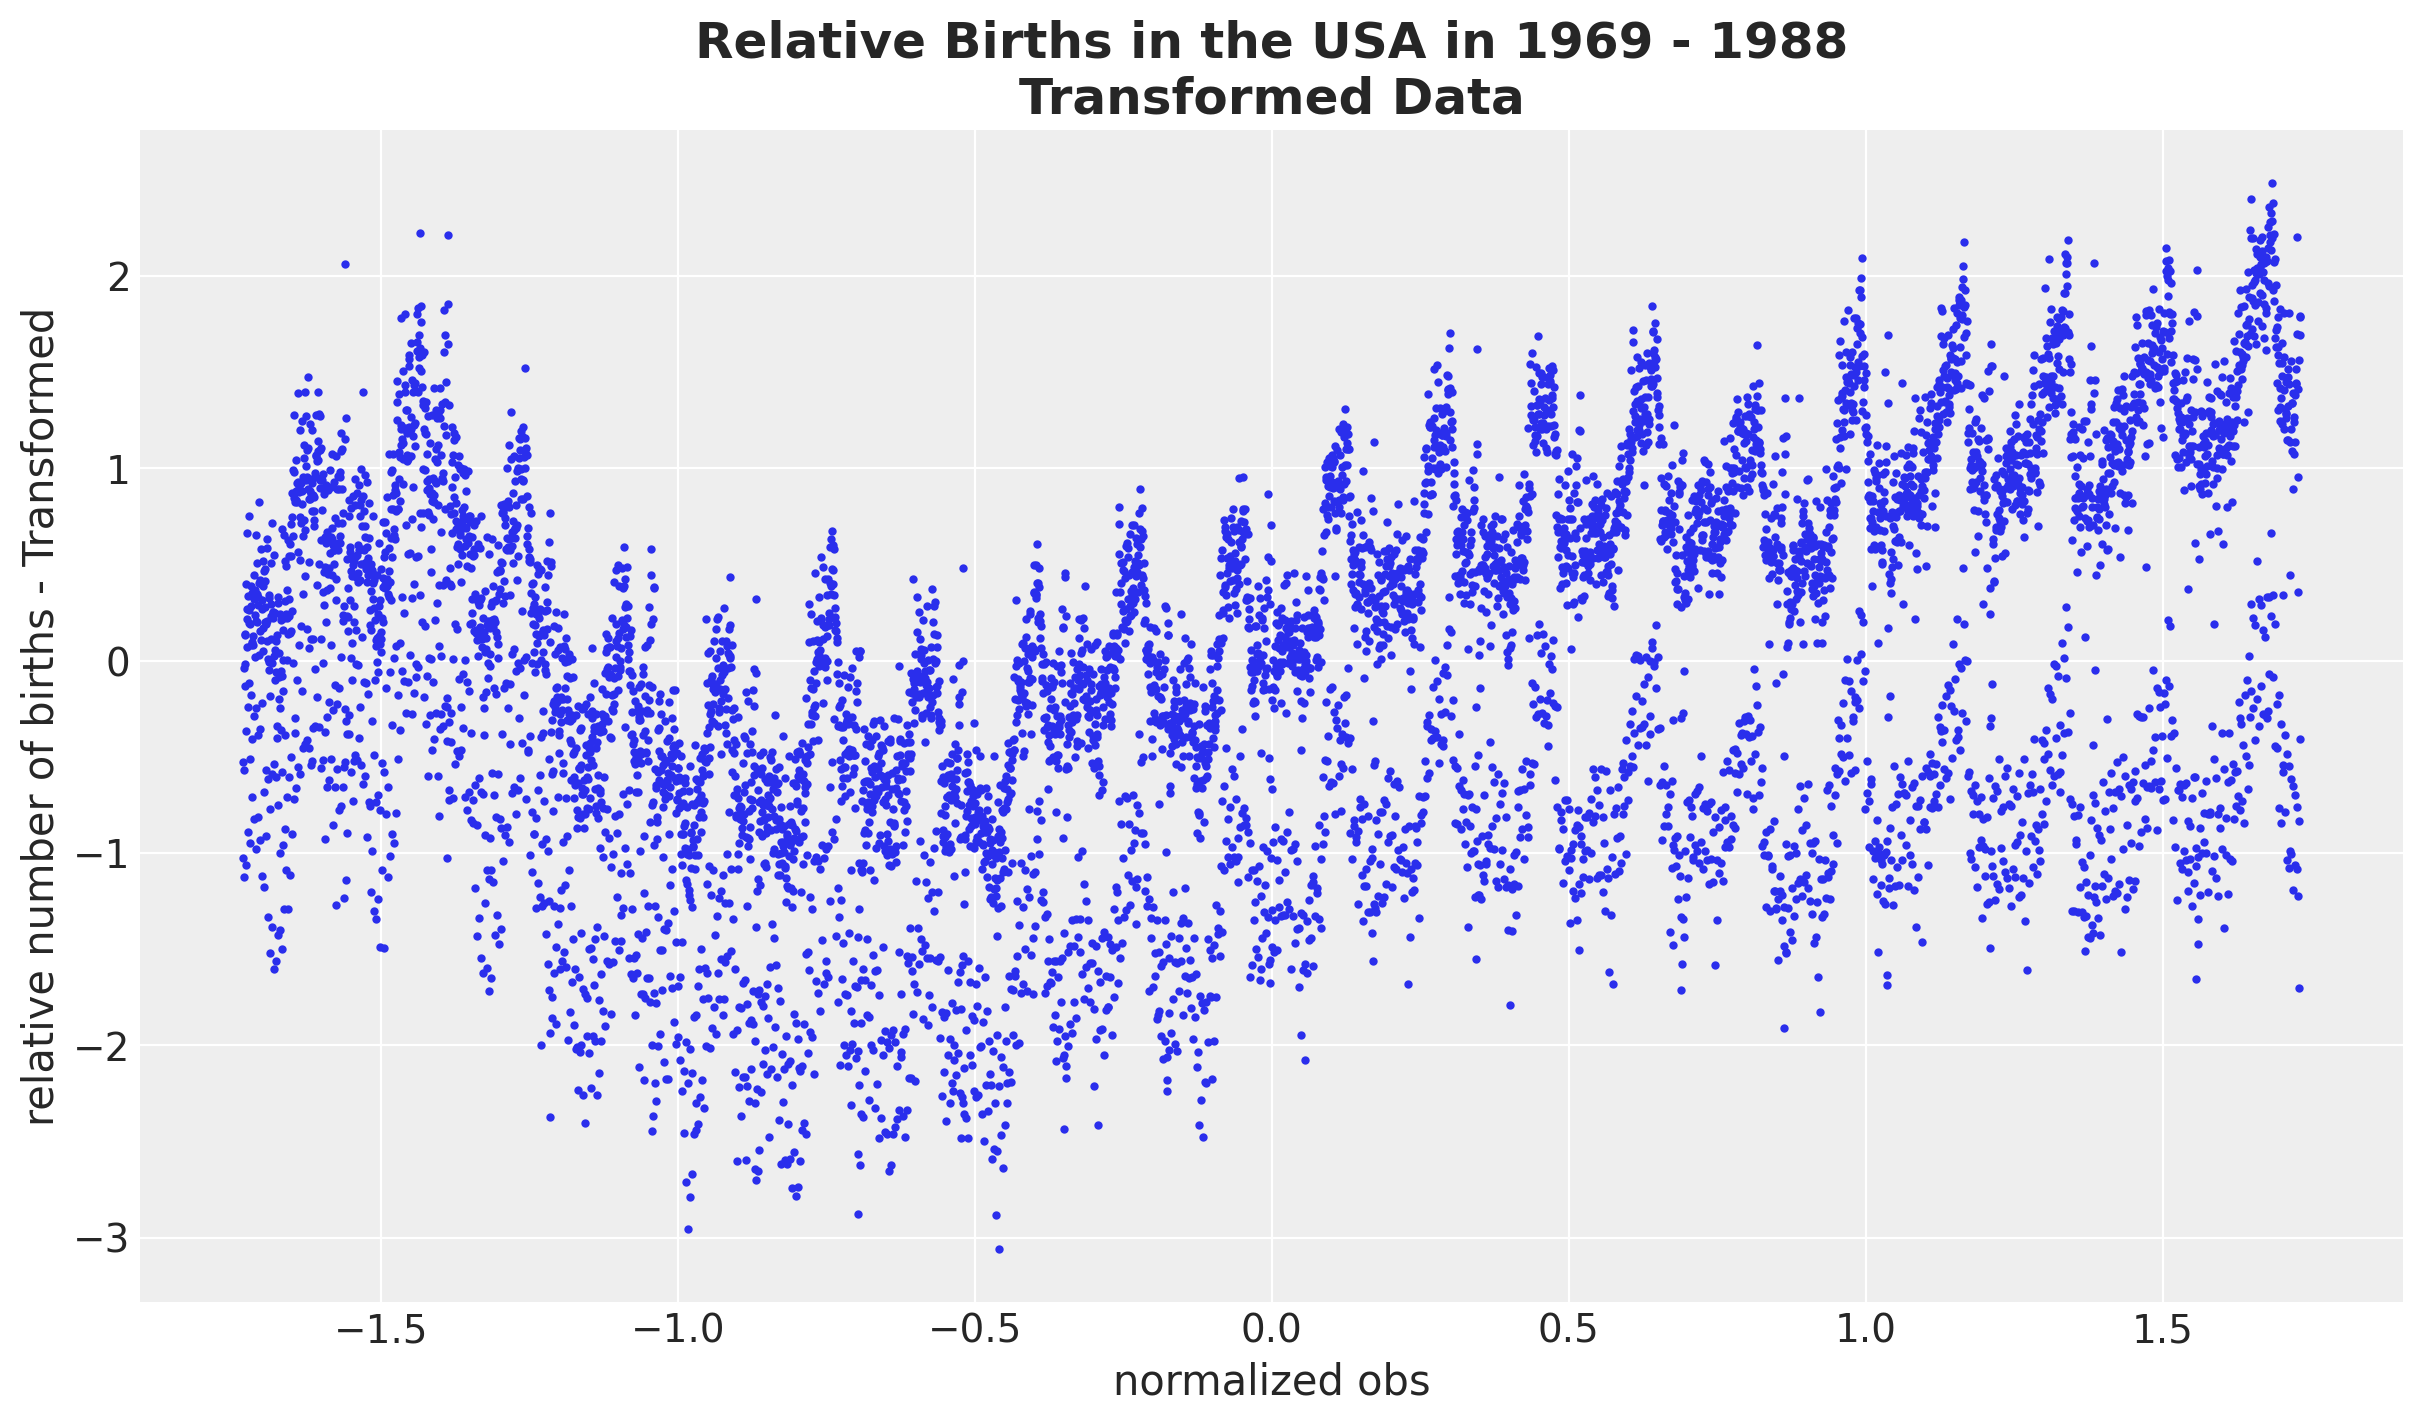

In [14]:
fig, ax = plt.subplots()
ax.plot(normalized_obs, normalized_log_births_relative100, "o", c="C0", markersize=2)
ax.set(xlabel="normalized obs", ylabel="relative number of births - Transformed")
ax.set_title(
    label="Relative Births in the USA in 1969 - 1988\nTransformed Data",
    fontsize=18,
    fontweight="bold",
)

## Model Specification

Text(0.5, 1.0, 'Prior distribution for the global trend Gaussian process')

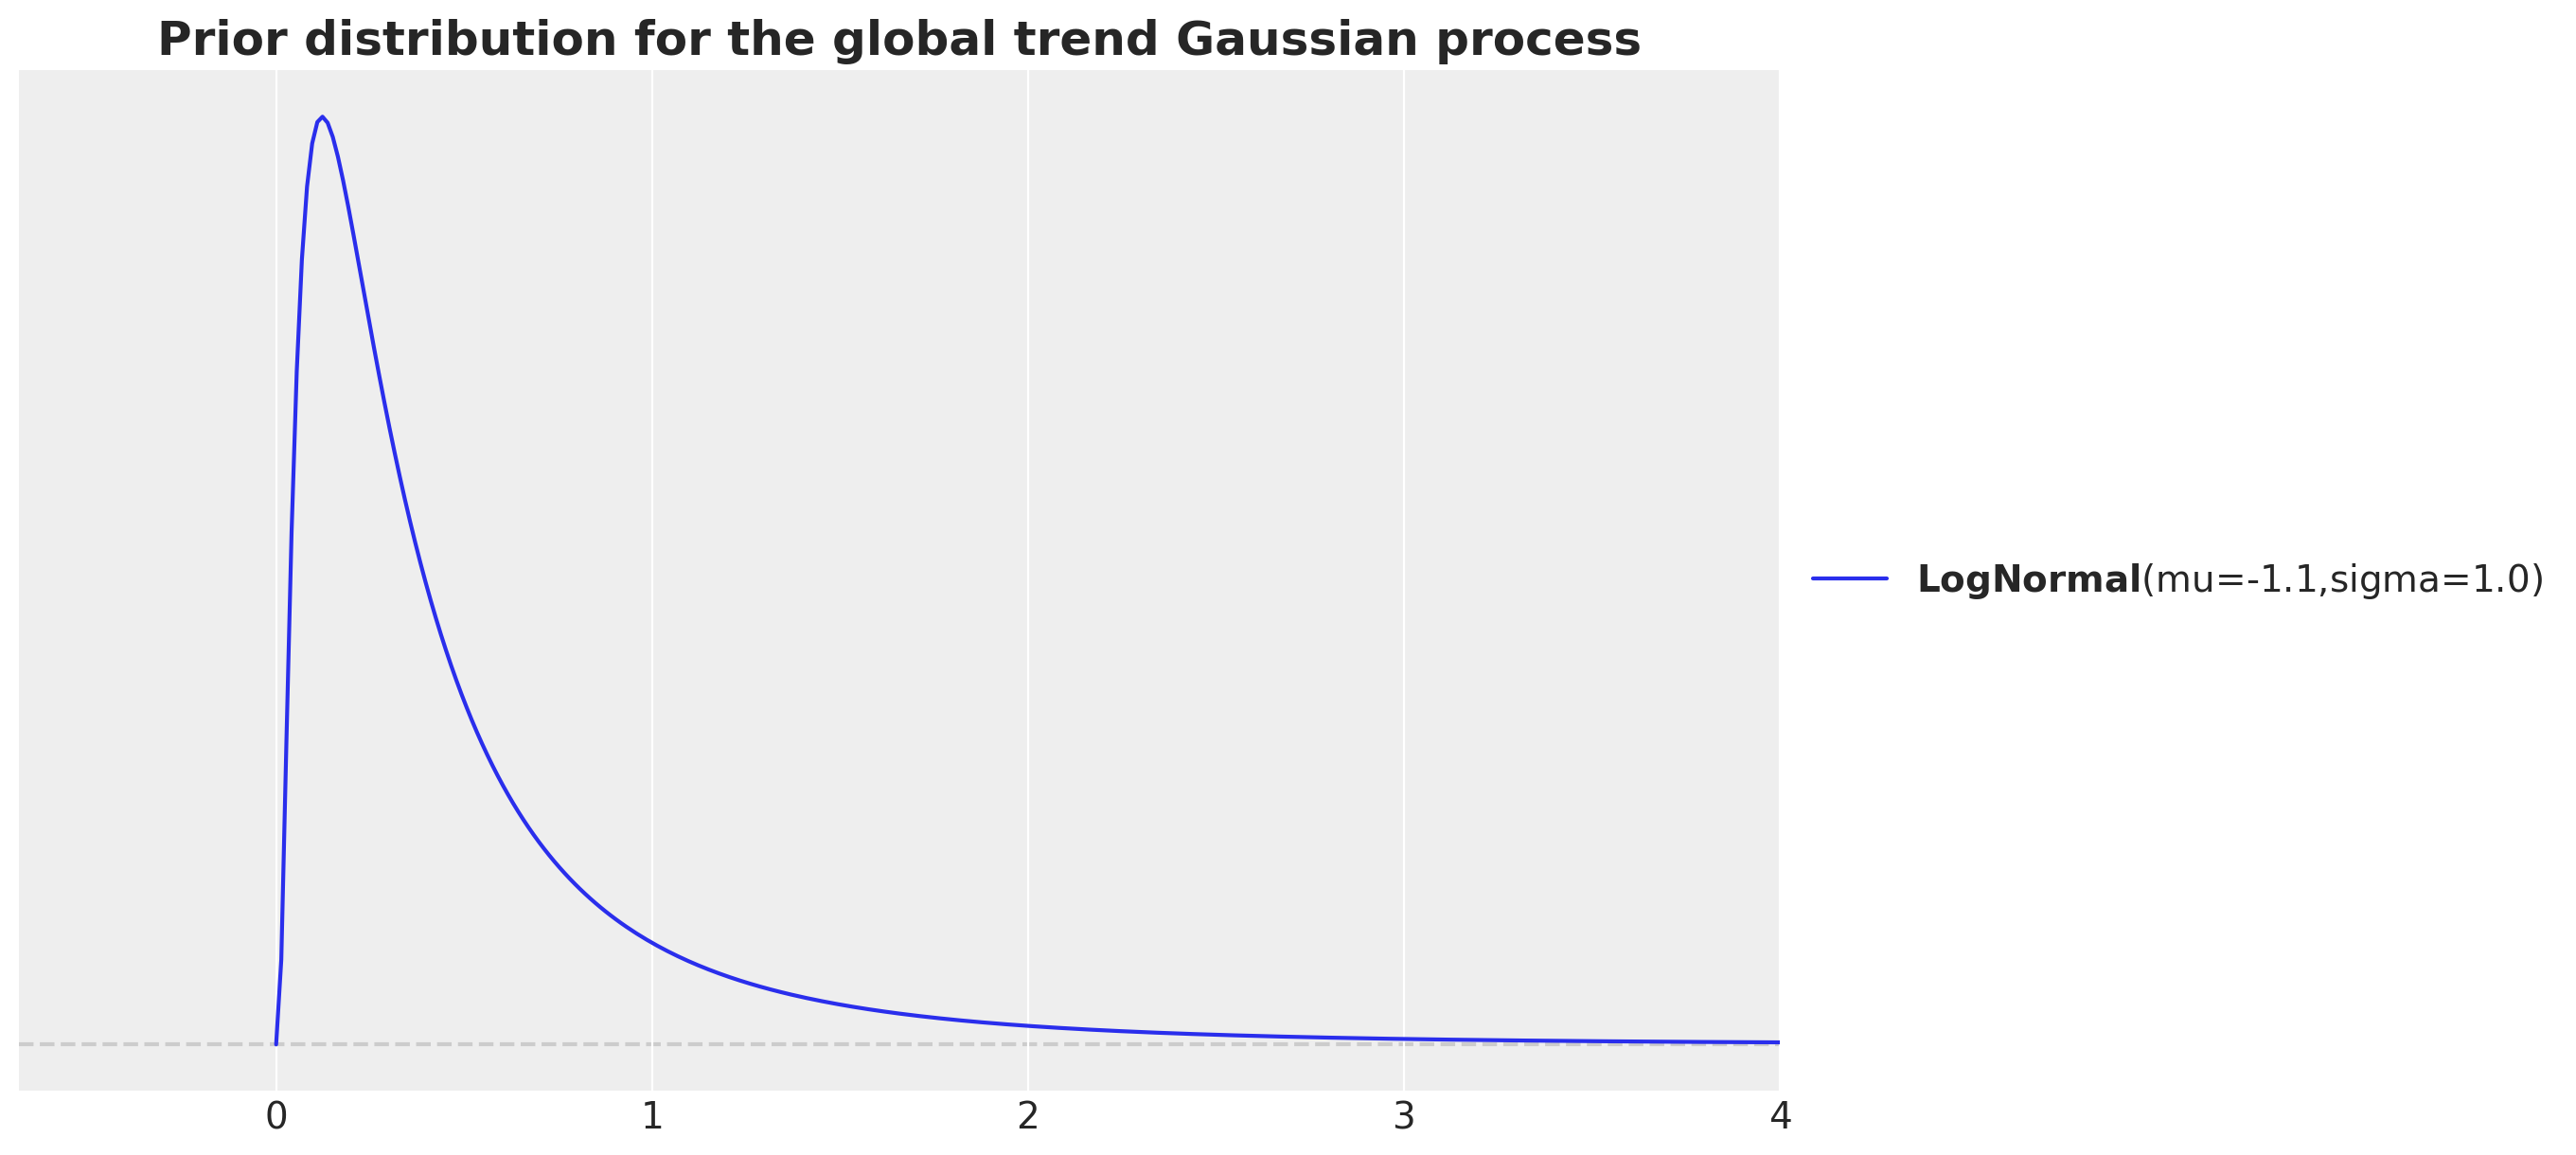

In [15]:
fig, ax = plt.subplots()
pz.LogNormal(mu=np.log(700 / obs_std), sigma=1).plot_pdf(ax=ax)
ax.set(xlim=(None, 4))
ax.set_title(
    label="Prior distribution for the global trend Gaussian process",
    fontsize=18,
    fontweight="bold",
)

Text(0.5, 1.0, 'Prior distribution for the Gaussian processes')

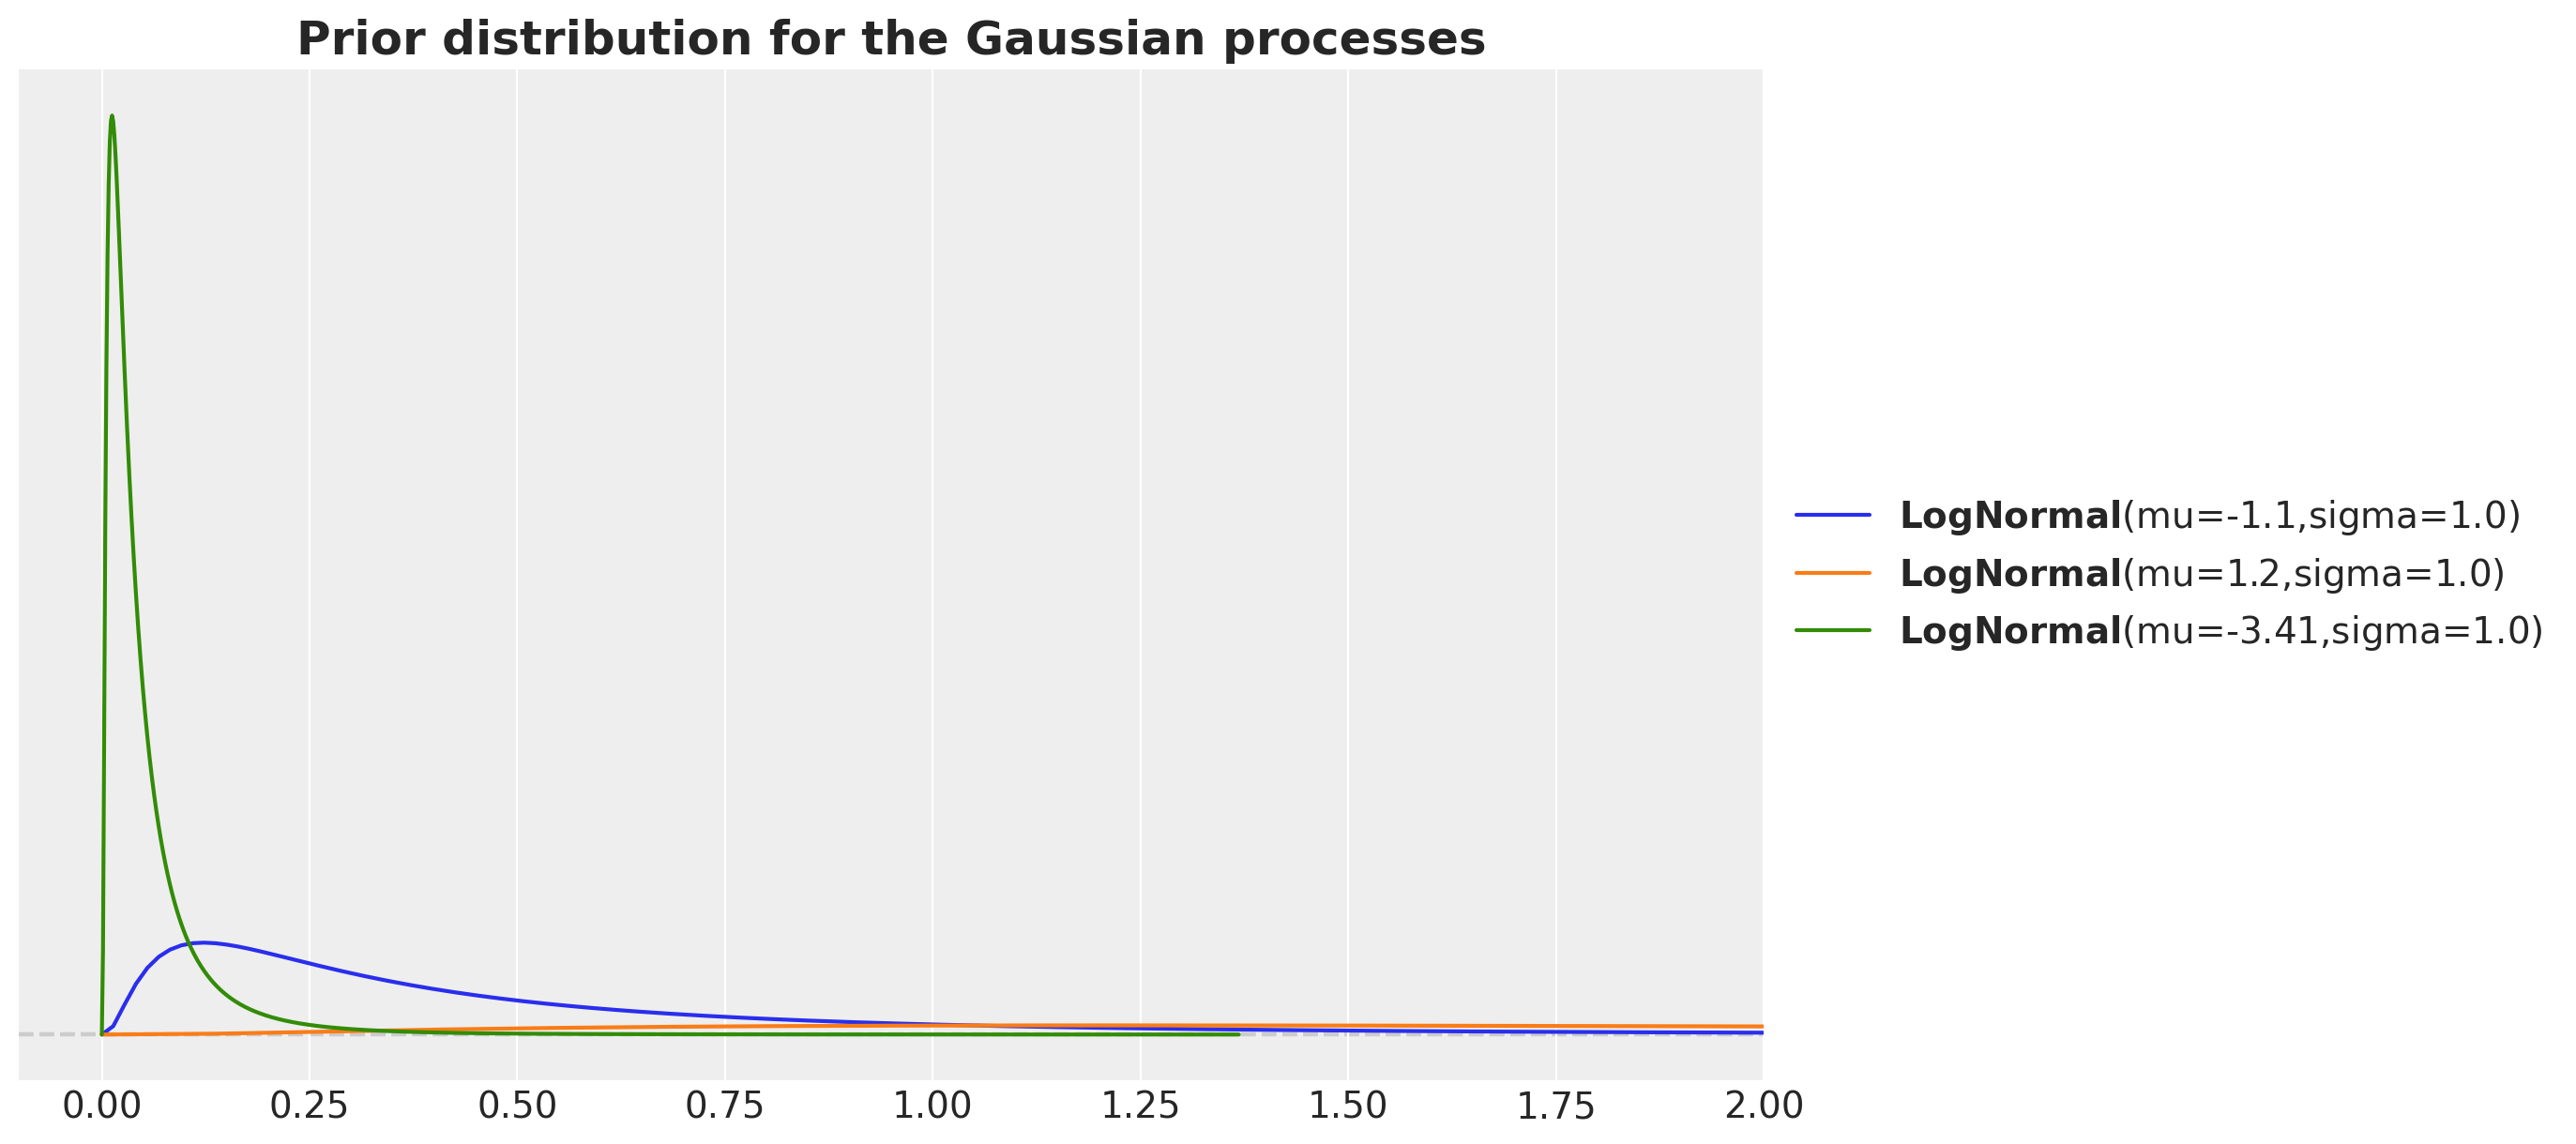

In [16]:
fig, ax = plt.subplots()
pz.LogNormal(mu=np.log(700 / obs_std), sigma=1).plot_pdf(ax=ax)
pz.LogNormal(mu=np.log(7_000 / obs_std), sigma=1).plot_pdf(ax=ax)
pz.LogNormal(mu=np.log(70 / obs_std), sigma=1).plot_pdf(ax=ax)
ax.set(xlim=(-0.1, 2))
ax.set_title(
    label="Prior distribution for the Gaussian processes",
    fontsize=18,
    fontweight="bold",
)

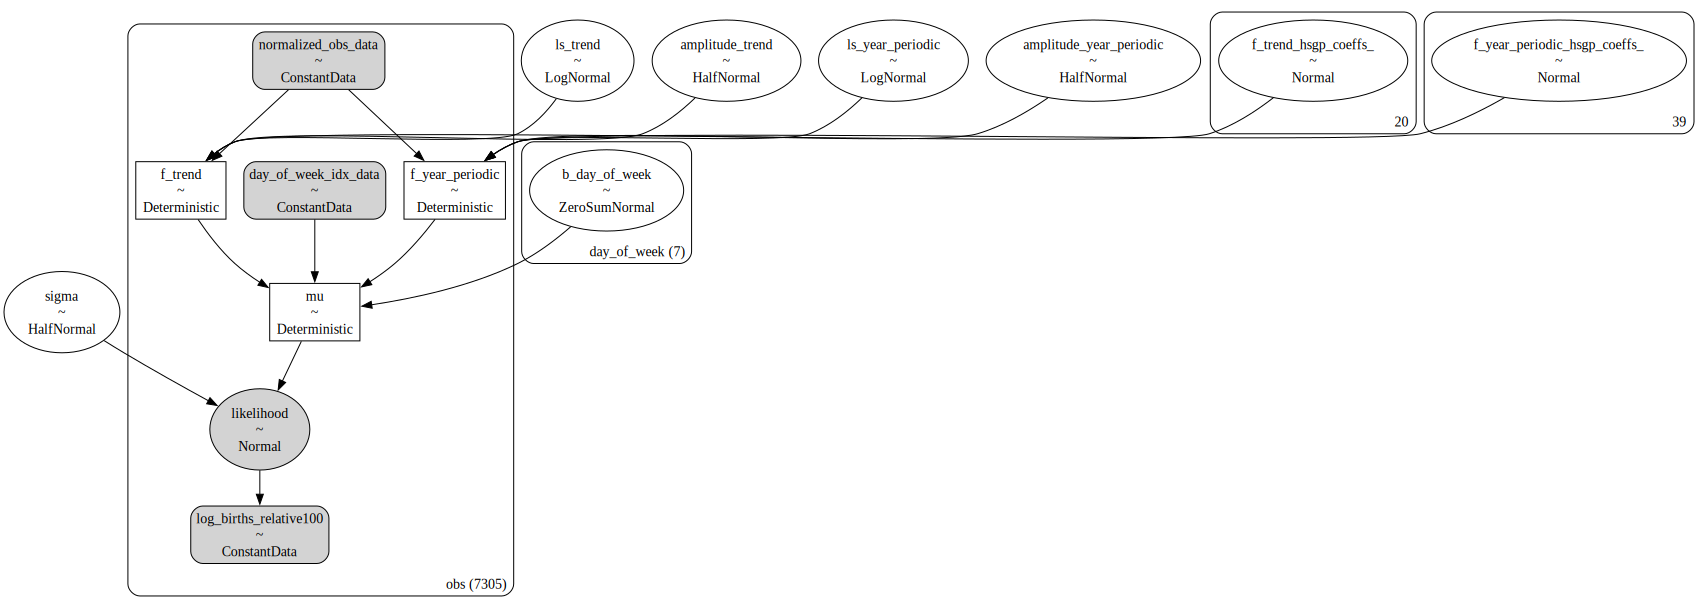

In [17]:
coords = {"obs": obs, "day_of_week": day_of_week, "day_of_year2": day_of_year2}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    normalized_obs_data = pm.Data(
        name="normalized_obs_data", value=normalized_obs, mutable=False, dims="obs"
    )

    day_of_week_idx_data = pm.Data(
        name="day_of_week_idx_data", value=day_of_week_idx, mutable=False, dims="obs"
    )
    normalized_log_births_relative100_data = pm.Data(
        name="log_births_relative100",
        value=normalized_log_births_relative100,
        mutable=False,
        dims="obs",
    )

    # --- Priors ---

    ## global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.LogNormal(name="ls_trend", mu=np.log(700 / obs_std), sigma=1)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=normalized_obs_data[:, None], dims="obs")

    ## year periodic
    amplitude_year_periodic = pm.HalfNormal(name="amplitude_year_periodic", sigma=1)
    ls_year_periodic = pm.LogNormal(name="ls_year_periodic", mu=np.log(7_000 / obs_std), sigma=1)
    gp_year_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_year_periodic,
        cov_func=pm.gp.cov.Periodic(input_dim=1, period=365.25 / obs_std, ls=ls_year_periodic),
    )
    f_year_periodic = gp_year_periodic.prior(
        name="f_year_periodic", X=normalized_obs_data[:, None], dims="obs"
    )

    ## day of week
    b_day_of_week = pm.ZeroSumNormal(name="b_day_of_week", sigma=1, dims="day_of_week")

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend + f_year_periodic + b_day_of_week[day_of_week_idx_data],
        dims="obs",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_log_births_relative100_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

## Prior Predictive Checks

In [18]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

/Users/juanitorduz/opt/anaconda3/envs/pymc-examples-env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [amplitude_trend, amplitude_year_periodic, b_day_of_week, f_trend_hsgp_coeffs_, f_year_periodic_hsgp_coeffs_, likelihood, ls_trend, ls_year_periodic, sigma]


/Users/juanitorduz/opt/anaconda3/envs/pymc-examples-env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Prior Predictive')

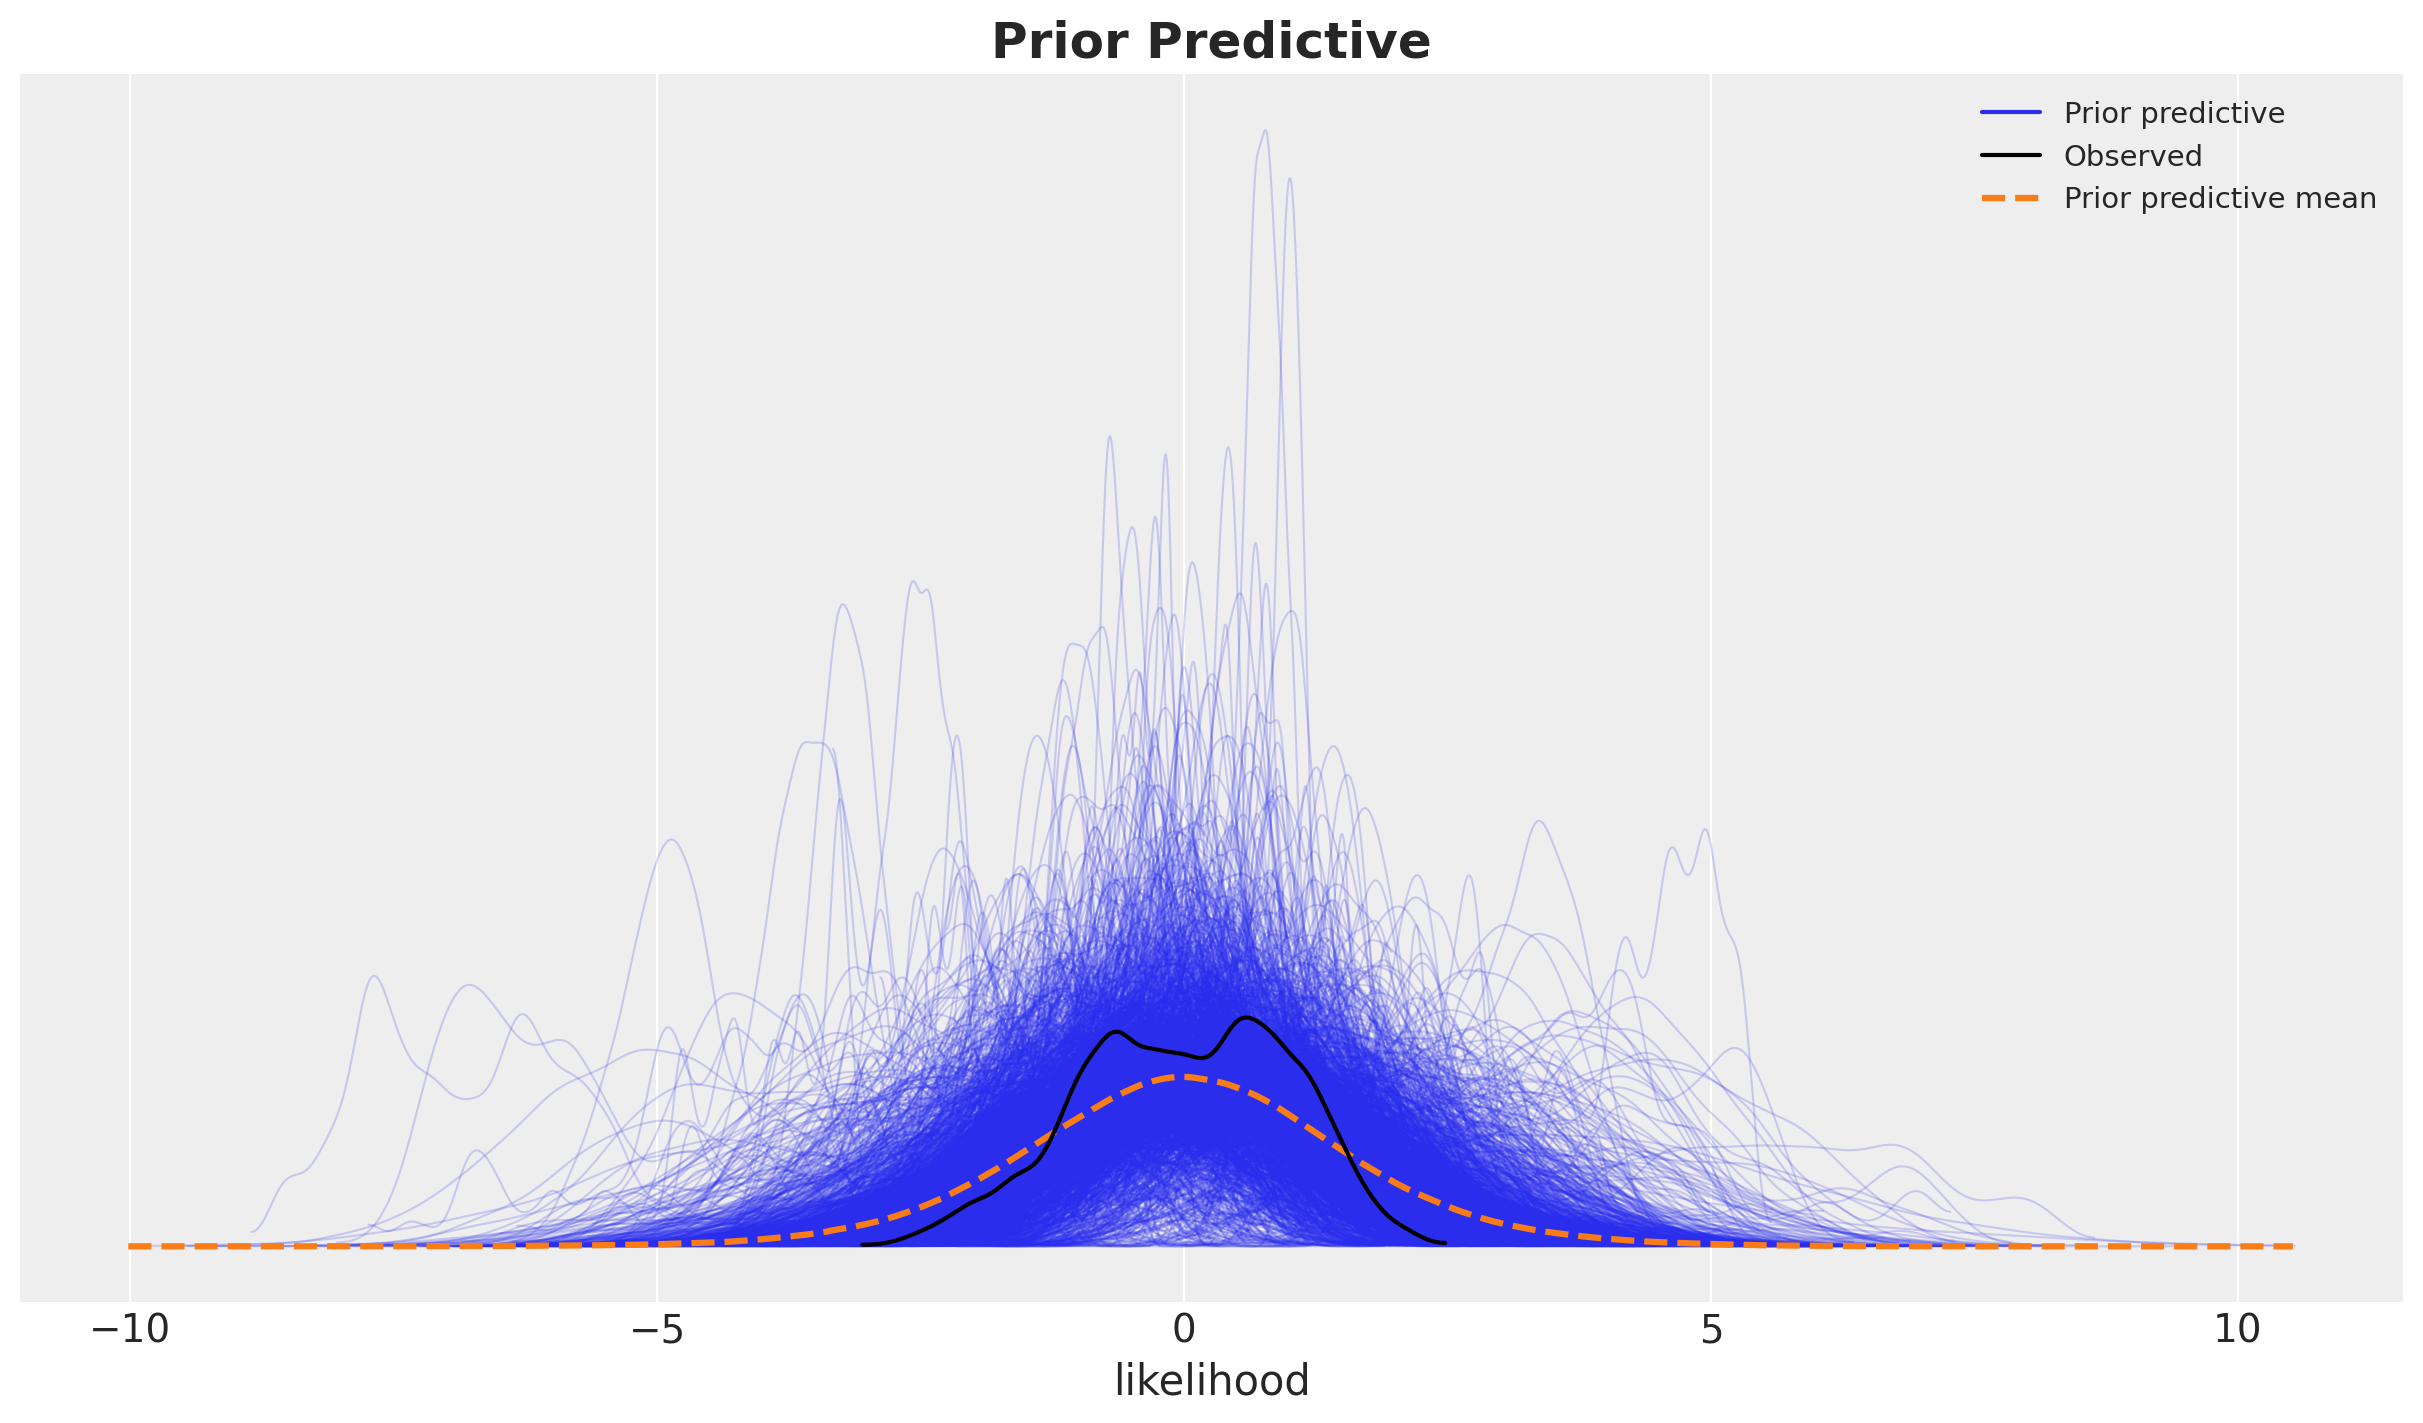

In [19]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")

## Model Fitting and Diagnostics

In [20]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=2_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/opt/anaconda3/envs/pymc-examples-env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Compiling...
/Users/juanitorduz/opt/anaconda3/envs/pymc-examples-env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/opt/anaconda3/envs/pymc-examples-env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/opt/anaconda3/envs/pymc-examples-env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: User

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:04:21.664919
Transforming variables...
Transformation time = 0:00:06.545745
Sampling: [likelihood]


In [21]:
idata["sample_stats"]["diverging"].sum().item()

0

In [22]:
var_names = [
    "amplitude_trend",
    "ls_trend",
    "amplitude_year_periodic",
    "ls_year_periodic",
    "b_day_of_week",
    "sigma",
]

az.summary(data=idata, var_names=var_names, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude_trend,0.381,0.194,0.133,0.711,0.004,0.003,2469.544,4438.187,1.003
ls_trend,0.199,0.040,0.124,0.269,0.001,0.001,2300.119,1914.096,1.003
amplitude_year_periodic,0.993,0.144,0.745,1.269,0.005,0.003,856.385,1782.344,1.003
ls_year_periodic,0.150,0.013,0.125,0.175,0.000,0.000,1325.400,2734.169,1.006
b_day_of_week[1],0.278,0.009,0.260,0.295,0.000,0.000,17724.242,5393.570,1.001
b_day_of_week[2],0.633,0.009,0.615,0.650,0.000,0.000,16269.865,5967.279,1.001
b_day_of_week[3],0.402,0.009,0.384,0.420,0.000,0.000,14176.753,5828.204,1.001
b_day_of_week[4],0.317,0.009,0.299,0.334,0.000,0.000,14826.633,5373.251,1.001
b_day_of_week[5],0.449,0.009,0.432,0.467,0.000,0.000,14937.811,6064.160,1.001
b_day_of_week[6],-0.831,0.009,-0.848,-0.813,0.000,0.000,15679.300,5923.856,1.000


## Posterior Distribution Analysis

## Authors
- Authored by [Juan Orduz](https://juanitorduz.github.io/) in January 2024 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Jan 16 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pytensor: 2.18.6

arviz     : 0.17.0
preliz    : 0.3.6
seaborn   : 0.13.1
pymc      : 5.10.3
numpy     : 1.26.3
matplotlib: 3.8.2
pytensor  : 2.18.6
xarray    : 2023.12.0
pandas    : 2.1.4

Watermark: 2.4.3



:::{include} ../page_footer.md
:::